Install Stuff

In [ ]:
!pip install datasets torch torchvision matplotlib tqdm scipy Pillow seaborn
!pip install torchmetrics torch-fidelity
!pip install torchmetrics[image]


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 32.3 MB/s eta 0:00:00


In [ ]:
!pip install pytorch_ssim

  Preparing metadata (setup.py) ... done
  Created wheel for pytorch_ssim: filename=pytorch_ssim-0.1-py3-none-any.whl size=2006 sha256=da9f02f7a56398556c4bbbc0b16cd8dc3894a9f86261117ec2500724bacec96f
  Stored in directory: /root/.cache/pip/wheels/54/a0/11/99f86224e71729ed9ef0c4ffe1b795807ad5f44bde19bc66f9
Successfully built pytorch_ssim


Import stuff

In [29]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, Dataset
from torchvision import transforms
import torchvision.utils as vutils
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from datasets import load_dataset
from torchvision.utils import make_grid
from torchvision.transforms import ToPILImage, ToTensor
from torchvision.models import inception_v3
from skimage.metrics import structural_similarity as ssim
from torchmetrics.functional import structural_similarity_index_measure as ssim1
from scipy.linalg import sqrtm
from torch.nn.functional import adaptive_avg_pool2d
from torchmetrics.image.fid import FrechetInceptionDistance
from torchvision.transforms.functional import resize
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import seaborn as sns
import torchvision.models as models
import pytorch_ssim
import random
random.seed(17)

mount google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
# # try random stuff to understand
# img_size = 32
# ds = load_dataset("valhalla/emoji-dataset", split="train")
# idx = 0
# img = ds[idx]['image']
# img2 = transforms.Resize((img_size, img_size))(img)
# img2_tensor = transforms.ToTensor()(img2)
# print(img2_tensor.shape)


import os
os.listdir('/content/drive/MyDrive')

['2df0c760baefbad552e14fe882b60a558502601384292_FRENCH.pdf',
 'The Importance of Inclusive Education(size 12).docx',
 'pdfcoffee.com_think-straight-change-your-thoughts-change-your-life-pdfdrivecom-pdf-2-pdf-free.pdf',
 'Allan_and_Barbara_Pease_-_Body_Language_The_Definitive_Book.pdf',
 'Learn Python The Hard Way 3rd Edition V413HAV.pdf',
 'Python+Syntax+Cheat+Sheet+Booklet (1).pdf',
 'Algorithms in C.pdf',
 'Thomas H. Cormen, Charles E. Leiserson, Ronald L. Rivest, Clifford Stein - Introduction to Algorithms-The MIT Press (2022).epub',
 '5.11.22 Corrected.PDF',
 'The C Programming Language- Brian W. Kernighan, Dennis M. Ritchie (1).pdf',
 'The C Programming Language- Brian W. Kernighan, Dennis M. Ritchie.pdf',
 'IMT2022017_assignment7.pdf',
 'skit (1)-2.gdoc',
 'assignment 1 maths 1.pdf',
 'math assignment 3.pdf',
 '01-11-2020-084536Surrounded by Idiots - Thomas Erikson_copy.pdf',
 'shoes.gdoc',
 'maths2 assignment10.pdf',
 'Portfolio-Session.pdf',
 'Resume_CV_Cover Letter Resources.p

hyperparams

In [ ]:
BATCH_SIZE=64 # to reduce fluctuation
IMG_SIZE=32
CODEBOOK_SIZE=256
HIDDEN_DIMENSION=256
EMBEDDING_DIMENSION=256 # also called z_dim in code
BETA=0.25 # commitment cost
vqvae_epochs=200
pixelcnn_epochs=300
TRANSFORMER_DIM = 256
PIXEL_CNN_LAYERS = 25

Load and proprocess dataset

In [ ]:
def get_emoji_dataloaders(batch_size=IMG_SIZE, img_size=IMG_SIZE):
    ds = load_dataset("valhalla/emoji-dataset", split="train")
    # print(type(ds))
    transform = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),  # [0,1]
    ])

    class EmojiDataset(torch.utils.data.Dataset):
        def __init__(self, hf_ds, transform):
            self.ds = hf_ds
            self.transform = transform

        def __len__(self):
            return len(self.ds)

        def __getitem__(self, idx):
            img = self.ds[idx]["image"]
            return self.transform(img), 0  # dummy label
            # after transform each img looks like (3, 32, 32)

    dataset = EmojiDataset(ds, transform)
    # this will be of shape (2749, 3, 32, 32) if there are 2749 elements in the dataset
    # not actually that shape, but when you get an item, it is of shape (3, 32, 32)
    # and there are 2749 items in ds....
    fraction = 0.9
    train_size = int(fraction * len(dataset))
    val_size = len(dataset) - train_size
    train_set, val_set = torch.utils.data.random_split(dataset, [train_size, val_size])
    # different type torch.utils.data.dataset.Subset
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, drop_last=True)
    val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)
    return train_loader, val_loader

# get_emoji_dataloaders(32, 32)

vqvae class and related code

In [ ]:
#Residual Block used in Encoder and Decoder
class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.block = nn.Sequential(
            nn.ReLU(),
            nn.Conv2d(channels, channels, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(channels, channels, kernel_size=1)
        )

    def forward(self, x):
        return x + self.block(x)

class Encoder(nn.Module):
    def __init__(self, in_channels=3, hidden_dim=128, z_dim=64):
        super().__init__()
        self.conv_stack = nn.Sequential(
            nn.Conv2d(in_channels, hidden_dim, kernel_size=4, stride=2, padding=1),  # 32 → 16
            nn.ReLU(),
            nn.Conv2d(hidden_dim, hidden_dim, kernel_size=4, stride=2, padding=1),   # 16 → 8
            nn.ReLU(),
            ResidualBlock(hidden_dim),
            ResidualBlock(hidden_dim),
            nn.Conv2d(hidden_dim, z_dim, kernel_size=1)
        )

    def forward(self, x):
        return self.conv_stack(x)

class Decoder(nn.Module):
    def __init__(self, out_channels=3, hidden_dim=128, z_dim=64):
        super().__init__()
        self.decode_stack = nn.Sequential(
            nn.Conv2d(z_dim, hidden_dim, kernel_size=3, padding=1),
            ResidualBlock(hidden_dim),
            ResidualBlock(hidden_dim),
            nn.ReLU(),
            nn.ConvTranspose2d(hidden_dim, hidden_dim, kernel_size=4, stride=2, padding=1),  # 8 → 16
            nn.ReLU(),
            nn.ConvTranspose2d(hidden_dim, out_channels, kernel_size=4, stride=2, padding=1),  # 16 → 32
            nn.Sigmoid() # Output in [0, 1] range
        )

    def forward(self, x):
        return self.decode_stack(x)

class VectorQuantizer(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, commitment_cost):
        super().__init__()
        self.embedding_dim = embedding_dim
        self.num_embeddings = num_embeddings
        self.commitment_cost = commitment_cost

        self.embeddings = nn.Embedding(num_embeddings, embedding_dim)
        self.embeddings.weight.data.uniform_(-1 / self.num_embeddings, 1 / self.num_embeddings)

    def get_code_indices(self, z):
        # Calculate distances and return indices (used for PixelCNN training/sampling)
        z_flat = z.permute(0, 2, 3, 1).contiguous().view(-1, self.embedding_dim)
        distances = (
            torch.sum(z_flat ** 2, dim=1, keepdim=True)
            + torch.sum(self.embeddings.weight ** 2, dim=1)
            - 2 * torch.matmul(z_flat, self.embeddings.weight.t())
        )
        encoding_indices = torch.argmin(distances, dim=1)
        return encoding_indices.view(z.shape[0], z.shape[2], z.shape[3]) # B x H x W

    def forward(self, z):
        z_flat = z.permute(0, 2, 3, 1).contiguous().view(-1, self.embedding_dim)
        distances = (
            torch.sum(z_flat ** 2, dim=1, keepdim=True)
            + torch.sum(self.embeddings.weight ** 2, dim=1)
            - 2 * torch.matmul(z_flat, self.embeddings.weight.t())
        )
        encoding_indices = torch.argmin(distances, dim=1).unsqueeze(1)
        encodings = torch.zeros(encoding_indices.size(0), self.num_embeddings, device=z.device)
        encodings.scatter_(1, encoding_indices, 1)

        quantized = torch.matmul(encodings, self.embeddings.weight).view(
            z.shape[0], z.shape[2], z.shape[3], self.embedding_dim
        ).permute(0, 3, 1, 2).contiguous()

        commitment_loss = F.mse_loss(quantized.detach(), z)
        embedding_loss = F.mse_loss(quantized, z.detach())
        loss = embedding_loss + self.commitment_cost * commitment_loss
        quantized = z + (quantized - z).detach()

        # return quantized, loss
        return quantized, loss, encoding_indices


class VectorQuantizerEMA(nn.Module):
    """
    Exponential Moving Average Vector Quantizer for VQ-VAE
    Args:
        num_embeddings: number of discrete codebook vectors
        embedding_dim: dimensionality of each code
        commitment_cost: β (how strongly encoder commits to a code)
        decay: EMA decay rate
        eps: small constant for numerical stability
    """
    def __init__(self, num_embeddings, embedding_dim, commitment_cost, decay=0.99, eps=1e-5):
        super().__init__()
        self.num_embeddings = num_embeddings
        self.embedding_dim = embedding_dim
        self.commitment_cost = commitment_cost
        self.decay = decay
        self.eps = eps

        embed = torch.randn(num_embeddings, embedding_dim)
        self.register_buffer("embedding", embed)
        self.register_buffer("ema_cluster_size", torch.zeros(num_embeddings))
        self.register_buffer("ema_w", embed.clone())

    def forward(self, z):
        """
        Args:
            z: continuous latent from encoder, shape (B, D, H, W)
        Returns:
            quantized: quantized tensor (B, D, H, W)
            loss: scalar commitment loss
            encoding_indices: discrete indices (B, H, W)
        """
        B, D, H, W = z.shape
        assert D == self.embedding_dim

        # Flatten input
        flat_z = z.permute(0, 2, 3, 1).contiguous().view(-1, D)

        # Compute distances to embeddings
        dist = (
            torch.sum(flat_z**2, dim=1, keepdim=True)
            + torch.sum(self.embedding**2, dim=1)
            - 2 * torch.matmul(flat_z, self.embedding.t())
        )

        # Get nearest embedding index for each vector
        encoding_indices = torch.argmin(dist, dim=1)
        encodings = F.one_hot(encoding_indices, self.num_embeddings).type(flat_z.dtype)

        # Quantize
        quantized_flat = torch.matmul(encodings, self.embedding)
        quantized = quantized_flat.view(B, H, W, D).permute(0, 3, 1, 2).contiguous()

        if self.training:
            # EMA updates
            cluster_size = encodings.sum(0)
            ema_w = torch.matmul(encodings.t(), flat_z)

            self.ema_cluster_size.data.mul_(self.decay).add_(cluster_size, alpha=1 - self.decay)
            self.ema_w.data.mul_(self.decay).add_(ema_w, alpha=1 - self.decay)

            n = torch.sum(self.ema_cluster_size)
            cluster_size = (
                (self.ema_cluster_size + self.eps)
                / (n + self.num_embeddings * self.eps)
                * n
            )
            self.embedding.data.copy_(self.ema_w / cluster_size.unsqueeze(1))

        # Compute commitment loss
        commitment_loss = self.commitment_cost * F.mse_loss(z, quantized.detach())

        # Straight-through estimator
        quantized = z + (quantized - z).detach()

        # reshape encoding indices for potential use
        encoding_indices = encoding_indices.view(B, H, W)
        return quantized, commitment_loss, encoding_indices


class VQVAE(nn.Module):
    def __init__(self, in_channels=3, hidden_dim=128, z_dim=64, num_embeddings=256, commitment_cost=0.25):
        super().__init__()
        self.encoder = Encoder(in_channels, hidden_dim, z_dim)
        self.quantizer = VectorQuantizer(num_embeddings, z_dim, commitment_cost)
        self.decoder = Decoder(in_channels, hidden_dim, z_dim)

    def forward(self, x):
        z_e = self.encoder(x)
        # z_q, vq_loss = self.quantizer(z_e)
        z_q, vq_loss, encoding_indices = self.quantizer(z_e)
        x_recon = self.decoder(z_q)
        # return x_recon, vq_loss
        return x_recon, vq_loss

    def get_latent_codes(self, x):
        # helps get only the discrete codes for pixel cnn/ other prior training
        z_e = self.encoder(x)
        return self.quantizer.get_code_indices(z_e)

    def decode_codes(self, codes):
        # Function to reconstruct images from discrete codes
        B, H, W = codes.shape
        quantized = self.quantizer.embeddings(codes).permute(0, 3, 1, 2) # B x D x H x W
        return self.decoder(quantized)



code to show reconstructions



In [ ]:
def show_reconstructions(model, val_loader, device):
    model.eval()
    imgs, _ = next(iter(val_loader))
    imgs = imgs.to(device)
    with torch.no_grad():
        recon, _ = model(imgs)

    # visualize
    n = min(8, imgs.size(0))
    orig = imgs[:n].cpu()
    recon = recon[:n].cpu()
    grid = torch.cat([orig, recon], dim=0)
    grid = vutils.make_grid(grid, nrow=n, normalize=True, scale_each=True)
    plt.figure(figsize=(12,6))
    plt.imshow(np.transpose(grid.numpy(), (1,2,0)))
    plt.title("Top: Original | Bottom: Reconstructed")
    plt.axis('off')
    plt.show()



def analyze_codebook_usage(model, all_indices, phase="Train"):
    """
    model: VQVAE model (must have .quantizer.num_embeddings)
    all_indices: torch.Tensor of shape [N, H, W] containing codebook indices
    phase: str, e.g., "Train Epoch 1", "Validation", "Generation"
    """
    indices = all_indices.view(-1).detach().cpu().numpy()
    num_embeddings = model.quantizer.num_embeddings

    counts, _ = np.histogram(indices, bins=np.arange(num_embeddings + 1))
    used = np.count_nonzero(counts)
    usage_percent = 100.0 * used / num_embeddings

    plt.figure(figsize=(8, 4))
    plt.bar(np.arange(num_embeddings), counts, color='steelblue')
    plt.title(f"{phase} — Codebook Usage: {used}/{num_embeddings} ({usage_percent:.2f}%)")
    plt.xlabel("Codebook Index")
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()

    return used, usage_percent



function for clustering codebook

In [ ]:
@torch.no_grad()
def visualize_latent_representations(model, data_loader, device, n_samples=16):
    model.eval()
    all_z_e, all_indices = [], []

    for imgs, _ in data_loader:
        imgs = imgs.to(device)
        z_e = model.encoder(imgs)
        indices = model.get_latent_codes(imgs)
        all_z_e.append(z_e.flatten(2).permute(0, 2, 1).reshape(-1, z_e.shape[1]).cpu())
        all_indices.append(indices.view(-1).cpu())
        if len(all_z_e[0]) > n_samples:  # limit number for visualization
            break

    z_e = torch.cat(all_z_e, dim=0)[:n_samples]
    indices = torch.cat(all_indices, dim=0)[:n_samples]

    # ---- 1. t-SNE of encoder outputs ----
    perplexity = min(30, (n_samples - 1) // 3)
    tsne = TSNE(n_components=2, perplexity=perplexity, learning_rate='auto', init='pca')
    z_embedded = tsne.fit_transform(z_e.numpy())

    plt.figure(figsize=(6, 6))
    sns.scatterplot(x=z_embedded[:, 0], y=z_embedded[:, 1],
                    hue=indices.numpy(), palette="tab20", legend=False, s=8)
    plt.title("t-SNE of Encoder Latent Space (colored by code index)")
    plt.show()

    # ---- 2. Clustering of codebook embeddings ----
    codebook = model.quantizer.embeddings.weight.detach().cpu().numpy()
    kmeans = KMeans(n_clusters=8, random_state=0).fit(codebook)
    plt.figure(figsize=(6, 6))
    sns.scatterplot(x=codebook[:, 0], y=codebook[:, 1],
                    hue=kmeans.labels_, palette="tab10", legend=False)
    plt.title("Clustering of Codebook Embeddings (K-Means)")
    plt.show()


vqvae training code

In [ ]:
def train_vqvae(model, train_loader, val_loader, device, num_epochs=10, lr=2e-4):
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    for epoch in range(1, num_epochs + 1):
        # Training phase
        model.train()
        total_train_loss = 0
        all_train_indices = []

        for imgs, _ in tqdm(train_loader, desc=f"Epoch {epoch} [Train]"):
            imgs = imgs.to(device)
            optimizer.zero_grad()

            # Forward
            recon, vq_loss = model(imgs)
            recon_loss = F.mse_loss(recon, imgs)
            loss = recon_loss + vq_loss

            # Backprop
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()

        avg_train_loss = total_train_loss / len(train_loader)

        if epoch % 10 != 0:
            continue

        # Codebook prints
        with torch.no_grad():
                indices = model.get_latent_codes(imgs)
                all_train_indices.append(indices.cpu())
                all_train_indices = torch.cat(all_train_indices, dim=0)
                analyze_codebook_usage(model, all_train_indices, phase=f"Train Epoch {epoch}")
        # Validation phase

        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for imgs, _ in tqdm(val_loader, desc=f"Epoch {epoch} [Val]", leave=False):
                imgs = imgs.to(device)
                recon, vq_loss = model(imgs)
                recon_loss = F.mse_loss(recon, imgs)
                loss = recon_loss + vq_loss
                total_val_loss += loss.item()

        avg_val_loss = total_val_loss / len(val_loader)

        print(f"Epoch {epoch}/{num_epochs} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

        # Optionally visualize reconstructions
        show_reconstructions(model, val_loader, device)





validation loss training with patience?!

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



def ssim_loss(x_recon, x_real):
    # torchmetrics expects values in [0,1]
    x_recon = torch.clamp(x_recon, 0, 1)
    x_real = torch.clamp(x_real, 0, 1)
    return 1 - ssim1(x_recon, x_real)

vgg = models.vgg16(weights='IMAGENET1K_V1').features[:16].eval().to(device)
for p in vgg.parameters():
    p.requires_grad = False

def perceptual_loss(x_recon, x_real):
    f_recon = vgg(x_recon)
    f_real = vgg(x_real)
    return F.mse_loss(f_recon, f_real)

def train_vqvae(model, train_loader, val_loader, device, num_epochs=10, lr=2e-4, patience=7):
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    best_val_loss = float('inf')
    epochs_no_improve = 0

    for epoch in range(1, num_epochs + 1):
        # ---- TRAINING ----
        model.train()
        total_train_loss = 0
        for imgs, _ in tqdm(train_loader, desc=f"Epoch {epoch} [Train]"):
            imgs = imgs.to(device)
            optimizer.zero_grad()

            recon, vq_loss = model(imgs)
            recon_loss = F.mse_loss(recon, imgs)
            per_loss = perceptual_loss(recon, imgs)
            ssim_loss1 = ssim_loss(recon, imgs)
            loss = recon_loss + vq_loss + 0.01 * perceptual_loss(recon, imgs) + 0.1*ssim_loss1
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            total_train_loss += loss.item()

        avg_train_loss = total_train_loss / len(train_loader)

        # ---- VALIDATION ----
        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for imgs, _ in tqdm(val_loader, desc=f"Epoch {epoch} [Val]", leave=False):
                imgs = imgs.to(device)
                recon, vq_loss = model(imgs)
                recon_loss = F.mse_loss(recon, imgs)
                loss = recon_loss + vq_loss + 0.01 * perceptual_loss(recon, imgs) + 0.1*ssim_loss(recon, imgs)
                total_val_loss += loss.item()

        avg_val_loss = total_val_loss / len(val_loader)

        print(f"Epoch {epoch}/{num_epochs} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")
        print(f'recon: {recon_loss} Perception loss: {per_loss} SSIM loss: {ssim_loss1}')

        # ---- EARLY STOPPING ----
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            epochs_no_improve = 0
            torch.save(model.state_dict(), "/content/drive/MyDrive/vqvae_emoji32.pth")
            print("Validation loss improved, model saved.")
        else:
            epochs_no_improve += 1
            print(f"No improvement for {epochs_no_improve} epoch(s).")

        if epochs_no_improve >= patience:
            print(f"Early stopping at epoch {epoch}. Best Val Loss: {best_val_loss:.4f}")
            break


train for inpainting task

In [45]:
# def random_mask(img, mask_size=8):
#     """
#     Applies a random mask of size `mask_size x mask_size` to a random location on the input image `img`.

#     Parameters:
#     - img: Tensor of shape [batch_size, channels, height, width]
#     - mask_size: Size of the square mask to apply

#     Returns:
#     - img_with_mask: Tensor with a masked region
#     - mask: The mask itself (for debugging or later use)
#     """
#     # Get image dimensions
#     _, _, h, w = img.shape

#     # Randomly pick the top-left corner of the mask
#     x = random.randint(0, w - mask_size)
#     y = random.randint(0, h - mask_size)

#     # Create the mask (mask_size x mask_size) of ones
#     mask = torch.ones_like(img)
#     mask[:, :, y:y + mask_size, x:x + mask_size] = 0

#     # Apply the mask to the image (set the masked region to 0)
#     img_with_mask = img * mask

#     return img_with_mask, mask

def random_mask(img, mask_size=8):
    """
    Applies a different random square mask to each image in the batch.

    Parameters:
    - img: Tensor of shape [B, C, H, W]
    - mask_size: int, size of the square mask

    Returns:
    - img_with_mask: Tensor with masked regions (same shape as img)
    - mask: Tensor of masks (1 where kept, 0 where masked)
    """
    B, C, H, W = img.shape
    mask = torch.ones_like(img)

    for i in range(B):
        # Random top-left corner for each image
        x = random.randint(0, W - mask_size)
        y = random.randint(0, H - mask_size)
        mask[i, :, y:y + mask_size, x:x + mask_size] = 0  # Apply per-image mask

    img_with_mask = img * mask
    return img_with_mask, mask


def train_vqvae_with_inpainting(model, train_loader, val_loader, device, num_epochs=10, lr=2e-4, patience=7):
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    best_val_loss = float('inf')
    epochs_no_improve = 0

    for epoch in range(1, num_epochs + 1):
        # ---- TRAINING ----
        model.train()
        total_train_loss = 0
        for imgs, _ in tqdm(train_loader, desc=f"Epoch {epoch} [Train]"):
            imgs = imgs.to(device)

            # Apply random mask to images during training
            masked_imgs, mask = random_mask(imgs, 8)

            # show the masked image
            # convert image to cpu
            # cpu_images = masked_imgs.cpu()
            # # show the first image in the batch
            # plt.imshow(cpu_images[0].permute(1, 2, 0))
            # plt.show()

            optimizer.zero_grad()

            # Forward pass with the masked images
            recon, vq_loss = model(masked_imgs)
            recon_loss = F.mse_loss(recon, imgs)  # Compare with original images
            per_loss = perceptual_loss(recon, imgs)
            ssim_loss1 = ssim_loss(recon, imgs)

            # Combine losses
            loss = recon_loss + vq_loss + 0.01 * per_loss + 0.1 * ssim_loss1
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            total_train_loss += loss.item()

        avg_train_loss = total_train_loss / len(train_loader)

        # ---- VALIDATION ----
        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for imgs, _ in tqdm(val_loader, desc=f"Epoch {epoch} [Val]", leave=False):
                imgs = imgs.to(device)

                # Optionally apply masking for validation as well
                masked_imgs, _ = random_mask(imgs)

                recon, vq_loss = model(masked_imgs)
                recon_loss = F.mse_loss(recon, imgs)
                loss = recon_loss + vq_loss + 0.01 * perceptual_loss(recon, imgs) + 0.1 * ssim_loss(recon, imgs)
                total_val_loss += loss.item()

        avg_val_loss = total_val_loss / len(val_loader)

        print(f"Epoch {epoch}/{num_epochs} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")
        print(f"Recon Loss: {recon_loss.item():.4f} | Perceptual Loss: {per_loss.item():.4f} | SSIM Loss: {ssim_loss1.item():.4f}")

        # ---- EARLY STOPPING ----
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            epochs_no_improve = 0
            torch.save(model.state_dict(), "/content/drive/MyDrive/vqvae_emoji32_inpainting.pth")
            print("Validation loss improved, model saved.")
        else:
            epochs_no_improve += 1
            print(f"No improvement for {epochs_no_improve} epoch(s).")

        if epochs_no_improve >= patience:
            print(f"Early stopping at epoch {epoch}. Best Val Loss: {best_val_loss:.4f}")
            break


run training

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_loader, val_loader = get_emoji_dataloaders(batch_size=32, img_size=32)
# model = VQVAE(in_channels=3, hidden_dim=64, z_dim=64, num_embeddings=256)
# model = VQVAE(in_channels=3, hidden_dim=128, z_dim=128, num_embeddings=512)
vqvae_model = VQVAE(
    in_channels=3,
    hidden_dim=HIDDEN_DIMENSION,     # increased
    z_dim=EMBEDDING_DIMENSION,          # increased
    num_embeddings=CODEBOOK_SIZE, # increased codebook size
    commitment_cost=BETA # tuned beta
)

train_vqvae(vqvae_model, train_loader, val_loader, device, num_epochs=vqvae_epochs)

Epoch 1 [Train]:   0%|          | 0/77 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torchmetrics/utilities/prints.py:70: FutureWarning: Importing `spectral_angle_mapper` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `spectral_angle_mapper` from `torchmetrics.image` instead.
  _future_warning(
Epoch 1 [Train]: 100%|██████████| 77/77 [00:10<00:00,  7.66it/s]


Epoch 1/200 | Train Loss: 19.3577 | Val Loss: 35.5117
recon: 0.048570867627859116 Perception loss: 15.055224418640137 SSIM loss: 0.70058274269104
Validation loss improved, model saved.


Epoch 2 [Train]: 100%|██████████| 77/77 [00:09<00:00,  7.93it/s]


Epoch 2/200 | Train Loss: 25.8373 | Val Loss: 30.7767
recon: 0.03860457241535187 Perception loss: 10.974197387695312 SSIM loss: 0.5124284625053406
Validation loss improved, model saved.


Epoch 3 [Train]: 100%|██████████| 77/77 [00:09<00:00,  8.39it/s]


Epoch 3/200 | Train Loss: 27.2018 | Val Loss: 14.7499
recon: 0.04047180339694023 Perception loss: 10.210531234741211 SSIM loss: 0.46010589599609375
Validation loss improved, model saved.


Epoch 4 [Train]: 100%|██████████| 77/77 [00:09<00:00,  7.71it/s]


Epoch 4/200 | Train Loss: 15.2848 | Val Loss: 10.4763
recon: 0.03796226903796196 Perception loss: 10.472091674804688 SSIM loss: 0.4779846668243408
Validation loss improved, model saved.


Epoch 5 [Train]: 100%|██████████| 77/77 [00:09<00:00,  7.94it/s]


Epoch 5/200 | Train Loss: 9.1705 | Val Loss: 5.3873
recon: 0.034612659364938736 Perception loss: 10.157403945922852 SSIM loss: 0.49027019739151
Validation loss improved, model saved.


Epoch 6 [Train]: 100%|██████████| 77/77 [00:09<00:00,  7.88it/s]


Epoch 6/200 | Train Loss: 4.6603 | Val Loss: 3.3529
recon: 0.032150719314813614 Perception loss: 9.904767036437988 SSIM loss: 0.42925333976745605
Validation loss improved, model saved.


Epoch 7 [Train]: 100%|██████████| 77/77 [00:09<00:00,  8.46it/s]


Epoch 7/200 | Train Loss: 2.6188 | Val Loss: 1.7091
recon: 0.02735239453613758 Perception loss: 9.437227249145508 SSIM loss: 0.38954198360443115
Validation loss improved, model saved.


Epoch 8 [Train]: 100%|██████████| 77/77 [00:09<00:00,  7.71it/s]


Epoch 8/200 | Train Loss: 1.4996 | Val Loss: 1.6340
recon: 0.023661404848098755 Perception loss: 7.680663108825684 SSIM loss: 0.3881608843803406
Validation loss improved, model saved.


Epoch 9 [Train]: 100%|██████████| 77/77 [00:09<00:00,  8.03it/s]


Epoch 9/200 | Train Loss: 1.3244 | Val Loss: 1.2034
recon: 0.019805945456027985 Perception loss: 8.222505569458008 SSIM loss: 0.33244073390960693
Validation loss improved, model saved.


Epoch 10 [Train]: 100%|██████████| 77/77 [00:10<00:00,  7.47it/s]


Epoch 10/200 | Train Loss: 1.1214 | Val Loss: 1.2041
recon: 0.02059098146855831 Perception loss: 6.804025650024414 SSIM loss: 0.33347415924072266
No improvement for 1 epoch(s).


Epoch 11 [Train]: 100%|██████████| 77/77 [00:09<00:00,  7.91it/s]


Epoch 11/200 | Train Loss: 0.8701 | Val Loss: 0.8284
recon: 0.017902782186865807 Perception loss: 7.058697700500488 SSIM loss: 0.3233557939529419
Validation loss improved, model saved.


Epoch 12 [Train]: 100%|██████████| 77/77 [00:09<00:00,  8.05it/s]


Epoch 12/200 | Train Loss: 0.7577 | Val Loss: 0.7367
recon: 0.016180219128727913 Perception loss: 7.070834636688232 SSIM loss: 0.35056746006011963
Validation loss improved, model saved.


Epoch 13 [Train]: 100%|██████████| 77/77 [00:08<00:00,  8.63it/s]


Epoch 13/200 | Train Loss: 0.6734 | Val Loss: 0.6903
recon: 0.01665748655796051 Perception loss: 6.667297840118408 SSIM loss: 0.3145137429237366
Validation loss improved, model saved.


Epoch 14 [Train]: 100%|██████████| 77/77 [00:09<00:00,  7.87it/s]


Epoch 14/200 | Train Loss: 0.6427 | Val Loss: 0.6120
recon: 0.015898000448942184 Perception loss: 5.903959274291992 SSIM loss: 0.29250723123550415
Validation loss improved, model saved.


Epoch 15 [Train]: 100%|██████████| 77/77 [00:09<00:00,  7.77it/s]


Epoch 15/200 | Train Loss: 0.5592 | Val Loss: 0.6426
recon: 0.015521204099059105 Perception loss: 4.906653881072998 SSIM loss: 0.2816397547721863
No improvement for 1 epoch(s).


Epoch 16 [Train]: 100%|██████████| 77/77 [00:09<00:00,  7.94it/s]


Epoch 16/200 | Train Loss: 0.5016 | Val Loss: 0.5553
recon: 0.013310535810887814 Perception loss: 5.117509841918945 SSIM loss: 0.2555423974990845
Validation loss improved, model saved.


Epoch 17 [Train]: 100%|██████████| 77/77 [00:09<00:00,  8.07it/s]


Epoch 17/200 | Train Loss: 0.4450 | Val Loss: 0.3824
recon: 0.012568121775984764 Perception loss: 4.7617926597595215 SSIM loss: 0.24785327911376953
Validation loss improved, model saved.


Epoch 18 [Train]: 100%|██████████| 77/77 [00:09<00:00,  8.42it/s]


Epoch 18/200 | Train Loss: 0.3805 | Val Loss: 0.3769
recon: 0.011671794578433037 Perception loss: 4.495992660522461 SSIM loss: 0.2410956621170044
Validation loss improved, model saved.


Epoch 19 [Train]: 100%|██████████| 77/77 [00:09<00:00,  8.08it/s]


Epoch 19/200 | Train Loss: 0.3298 | Val Loss: 0.3293
recon: 0.010983624495565891 Perception loss: 4.080751895904541 SSIM loss: 0.23867976665496826
Validation loss improved, model saved.


Epoch 20 [Train]: 100%|██████████| 77/77 [00:09<00:00,  7.73it/s]


Epoch 20/200 | Train Loss: 0.2925 | Val Loss: 0.3100
recon: 0.010290652513504028 Perception loss: 5.463043212890625 SSIM loss: 0.24831175804138184
Validation loss improved, model saved.


Epoch 21 [Train]: 100%|██████████| 77/77 [00:09<00:00,  7.88it/s]


Epoch 21/200 | Train Loss: 0.2663 | Val Loss: 0.2661
recon: 0.01050980482250452 Perception loss: 3.751852512359619 SSIM loss: 0.1938176155090332
Validation loss improved, model saved.


Epoch 22 [Train]: 100%|██████████| 77/77 [00:09<00:00,  7.82it/s]


Epoch 22/200 | Train Loss: 0.2419 | Val Loss: 0.2448
recon: 0.009609046392142773 Perception loss: 3.9496963024139404 SSIM loss: 0.20877856016159058
Validation loss improved, model saved.


Epoch 23 [Train]: 100%|██████████| 77/77 [00:09<00:00,  8.43it/s]


Epoch 23/200 | Train Loss: 0.2249 | Val Loss: 0.2344
recon: 0.010057581588625908 Perception loss: 3.4363694190979004 SSIM loss: 0.18992209434509277
Validation loss improved, model saved.


Epoch 24 [Train]: 100%|██████████| 77/77 [00:09<00:00,  7.94it/s]


Epoch 24/200 | Train Loss: 0.2180 | Val Loss: 0.2233
recon: 0.009096548892557621 Perception loss: 3.315275192260742 SSIM loss: 0.17633259296417236
Validation loss improved, model saved.


Epoch 25 [Train]: 100%|██████████| 77/77 [00:09<00:00,  7.77it/s]


Epoch 25/200 | Train Loss: 0.2120 | Val Loss: 0.2350
recon: 0.008839137852191925 Perception loss: 3.2910349369049072 SSIM loss: 0.18364185094833374
No improvement for 1 epoch(s).


Epoch 26 [Train]: 100%|██████████| 77/77 [00:09<00:00,  7.86it/s]


Epoch 26/200 | Train Loss: 0.2063 | Val Loss: 0.2146
recon: 0.008464941754937172 Perception loss: 3.124755859375 SSIM loss: 0.17159885168075562
Validation loss improved, model saved.


Epoch 27 [Train]: 100%|██████████| 77/77 [00:09<00:00,  8.02it/s]


Epoch 27/200 | Train Loss: 0.1959 | Val Loss: 0.2081
recon: 0.008700474165380001 Perception loss: 3.0846292972564697 SSIM loss: 0.1754894256591797
Validation loss improved, model saved.


Epoch 28 [Train]: 100%|██████████| 77/77 [00:08<00:00,  8.68it/s]


Epoch 28/200 | Train Loss: 0.1802 | Val Loss: 0.1876
recon: 0.007834265008568764 Perception loss: 2.889259099960327 SSIM loss: 0.16509246826171875
Validation loss improved, model saved.


Epoch 29 [Train]: 100%|██████████| 77/77 [00:09<00:00,  8.02it/s]


Epoch 29/200 | Train Loss: 0.1727 | Val Loss: 0.1773
recon: 0.007412343751639128 Perception loss: 3.020685911178589 SSIM loss: 0.17372745275497437
Validation loss improved, model saved.


Epoch 30 [Train]: 100%|██████████| 77/77 [00:09<00:00,  7.96it/s]


Epoch 30/200 | Train Loss: 0.1594 | Val Loss: 0.1821
recon: 0.007440488785505295 Perception loss: 2.5728096961975098 SSIM loss: 0.15797638893127441
No improvement for 1 epoch(s).


Epoch 31 [Train]: 100%|██████████| 77/77 [00:09<00:00,  7.92it/s]


Epoch 31/200 | Train Loss: 0.1529 | Val Loss: 0.1818
recon: 0.007408355362713337 Perception loss: 2.689452648162842 SSIM loss: 0.15561002492904663
No improvement for 2 epoch(s).


Epoch 32 [Train]: 100%|██████████| 77/77 [00:09<00:00,  8.20it/s]


Epoch 32/200 | Train Loss: 0.1459 | Val Loss: 0.1641
recon: 0.007103953510522842 Perception loss: 3.0543315410614014 SSIM loss: 0.17071807384490967
Validation loss improved, model saved.


Epoch 33 [Train]: 100%|██████████| 77/77 [00:09<00:00,  8.49it/s]


Epoch 33/200 | Train Loss: 0.1369 | Val Loss: 0.1509
recon: 0.006837478838860989 Perception loss: 2.3671963214874268 SSIM loss: 0.15740108489990234
Validation loss improved, model saved.


Epoch 34 [Train]: 100%|██████████| 77/77 [00:09<00:00,  7.70it/s]


Epoch 34/200 | Train Loss: 0.1283 | Val Loss: 0.1470
recon: 0.006598492152988911 Perception loss: 2.3183484077453613 SSIM loss: 0.1524066925048828
Validation loss improved, model saved.


Epoch 35 [Train]: 100%|██████████| 77/77 [00:10<00:00,  7.66it/s]


Epoch 35/200 | Train Loss: 0.1245 | Val Loss: 0.1450
recon: 0.006522636394947767 Perception loss: 2.046316385269165 SSIM loss: 0.1420900821685791
Validation loss improved, model saved.


Epoch 36 [Train]: 100%|██████████| 77/77 [00:09<00:00,  7.87it/s]


Epoch 36/200 | Train Loss: 0.1185 | Val Loss: 0.1342
recon: 0.00613799225538969 Perception loss: 1.7826037406921387 SSIM loss: 0.13455885648727417
Validation loss improved, model saved.


Epoch 37 [Train]: 100%|██████████| 77/77 [00:09<00:00,  8.22it/s]


Epoch 37/200 | Train Loss: 0.1140 | Val Loss: 0.1349
recon: 0.005994854494929314 Perception loss: 1.824090600013733 SSIM loss: 0.13707375526428223
No improvement for 1 epoch(s).


Epoch 38 [Train]: 100%|██████████| 77/77 [00:09<00:00,  8.27it/s]


Epoch 38/200 | Train Loss: 0.1100 | Val Loss: 0.1282
recon: 0.006120776757597923 Perception loss: 2.0344667434692383 SSIM loss: 0.144506573677063
Validation loss improved, model saved.


Epoch 39 [Train]: 100%|██████████| 77/77 [00:09<00:00,  7.93it/s]


Epoch 39/200 | Train Loss: 0.1060 | Val Loss: 0.1281
recon: 0.005938083399087191 Perception loss: 1.9460777044296265 SSIM loss: 0.14645522832870483
Validation loss improved, model saved.


Epoch 40 [Train]: 100%|██████████| 77/77 [00:10<00:00,  7.61it/s]


Epoch 40/200 | Train Loss: 0.1023 | Val Loss: 0.1208
recon: 0.005686718039214611 Perception loss: 1.969735026359558 SSIM loss: 0.14130544662475586
Validation loss improved, model saved.


Epoch 41 [Train]: 100%|██████████| 77/77 [00:09<00:00,  7.88it/s]


Epoch 41/200 | Train Loss: 0.0997 | Val Loss: 0.1214
recon: 0.005979497916996479 Perception loss: 1.7363812923431396 SSIM loss: 0.1229088306427002
No improvement for 1 epoch(s).


Epoch 42 [Train]: 100%|██████████| 77/77 [00:09<00:00,  8.26it/s]


Epoch 42/200 | Train Loss: 0.0971 | Val Loss: 0.1164
recon: 0.005609212443232536 Perception loss: 2.1416873931884766 SSIM loss: 0.14426934719085693
Validation loss improved, model saved.


Epoch 43 [Train]: 100%|██████████| 77/77 [00:09<00:00,  8.37it/s]


Epoch 43/200 | Train Loss: 0.0938 | Val Loss: 0.1152
recon: 0.005793753545731306 Perception loss: 1.375192403793335 SSIM loss: 0.10998249053955078
Validation loss improved, model saved.


Epoch 44 [Train]: 100%|██████████| 77/77 [00:09<00:00,  7.74it/s]


Epoch 44/200 | Train Loss: 0.0894 | Val Loss: 0.1092
recon: 0.005598851013928652 Perception loss: 1.7630722522735596 SSIM loss: 0.12381279468536377
Validation loss improved, model saved.


Epoch 45 [Train]: 100%|██████████| 77/77 [00:09<00:00,  7.84it/s]


Epoch 45/200 | Train Loss: 0.0866 | Val Loss: 0.1078
recon: 0.005497713107615709 Perception loss: 1.4317134618759155 SSIM loss: 0.11008328199386597
Validation loss improved, model saved.


Epoch 46 [Train]: 100%|██████████| 77/77 [00:09<00:00,  7.92it/s]


Epoch 46/200 | Train Loss: 0.0852 | Val Loss: 0.1081
recon: 0.0056840805336833 Perception loss: 1.3404563665390015 SSIM loss: 0.11315417289733887
No improvement for 1 epoch(s).


Epoch 47 [Train]: 100%|██████████| 77/77 [00:09<00:00,  8.39it/s]


Epoch 47/200 | Train Loss: 0.0829 | Val Loss: 0.1039
recon: 0.005422299262136221 Perception loss: 1.610872745513916 SSIM loss: 0.11911982297897339
Validation loss improved, model saved.


Epoch 48 [Train]: 100%|██████████| 77/77 [00:09<00:00,  8.22it/s]


Epoch 48/200 | Train Loss: 0.0811 | Val Loss: 0.1018
recon: 0.005474161356687546 Perception loss: 1.805393099784851 SSIM loss: 0.12368202209472656
Validation loss improved, model saved.


Epoch 49 [Train]: 100%|██████████| 77/77 [00:09<00:00,  7.78it/s]


Epoch 49/200 | Train Loss: 0.0784 | Val Loss: 0.0990
recon: 0.005199618637561798 Perception loss: 1.5341532230377197 SSIM loss: 0.1006174087524414
Validation loss improved, model saved.


Epoch 50 [Train]: 100%|██████████| 77/77 [00:09<00:00,  7.83it/s]


Epoch 50/200 | Train Loss: 0.0765 | Val Loss: 0.0996
recon: 0.005487092304974794 Perception loss: 1.321414589881897 SSIM loss: 0.11437571048736572
No improvement for 1 epoch(s).


Epoch 51 [Train]: 100%|██████████| 77/77 [00:09<00:00,  7.71it/s]


Epoch 51/200 | Train Loss: 0.0740 | Val Loss: 0.0955
recon: 0.00503322621807456 Perception loss: 1.1044023036956787 SSIM loss: 0.09739744663238525
Validation loss improved, model saved.


Epoch 52 [Train]: 100%|██████████| 77/77 [00:08<00:00,  8.56it/s]


Epoch 52/200 | Train Loss: 0.0730 | Val Loss: 0.0961
recon: 0.005297562573105097 Perception loss: 1.35356867313385 SSIM loss: 0.1140245795249939
No improvement for 1 epoch(s).


Epoch 53 [Train]: 100%|██████████| 77/77 [00:09<00:00,  8.16it/s]


Epoch 53/200 | Train Loss: 0.0712 | Val Loss: 0.0931
recon: 0.005148847587406635 Perception loss: 1.0370118618011475 SSIM loss: 0.09005904197692871
Validation loss improved, model saved.


Epoch 54 [Train]: 100%|██████████| 77/77 [00:09<00:00,  7.88it/s]


Epoch 54/200 | Train Loss: 0.0691 | Val Loss: 0.0930
recon: 0.005293712951242924 Perception loss: 1.3235607147216797 SSIM loss: 0.10606777667999268
Validation loss improved, model saved.


Epoch 55 [Train]: 100%|██████████| 77/77 [00:10<00:00,  7.63it/s]


Epoch 55/200 | Train Loss: 0.0679 | Val Loss: 0.0885
recon: 0.004924127832055092 Perception loss: 0.9897379875183105 SSIM loss: 0.0832071304321289
Validation loss improved, model saved.


Epoch 56 [Train]: 100%|██████████| 77/77 [00:09<00:00,  7.96it/s]


Epoch 56/200 | Train Loss: 0.0661 | Val Loss: 0.0895
recon: 0.005118027329444885 Perception loss: 1.1504062414169312 SSIM loss: 0.09608149528503418
No improvement for 1 epoch(s).


Epoch 57 [Train]: 100%|██████████| 77/77 [00:09<00:00,  8.47it/s]


Epoch 57/200 | Train Loss: 0.0648 | Val Loss: 0.0878
recon: 0.004929407499730587 Perception loss: 1.1346746683120728 SSIM loss: 0.10720336437225342
Validation loss improved, model saved.


Epoch 58 [Train]: 100%|██████████| 77/77 [00:09<00:00,  7.76it/s]


Epoch 58/200 | Train Loss: 0.0628 | Val Loss: 0.0863
recon: 0.004811788443475962 Perception loss: 1.1143290996551514 SSIM loss: 0.09742295742034912
Validation loss improved, model saved.


Epoch 59 [Train]: 100%|██████████| 77/77 [00:09<00:00,  7.85it/s]


Epoch 59/200 | Train Loss: 0.0610 | Val Loss: 0.0846
recon: 0.004833937622606754 Perception loss: 0.9679900407791138 SSIM loss: 0.08421200513839722
Validation loss improved, model saved.


Epoch 60 [Train]: 100%|██████████| 77/77 [00:10<00:00,  7.56it/s]


Epoch 60/200 | Train Loss: 0.0603 | Val Loss: 0.0834
recon: 0.004712751600891352 Perception loss: 1.0852833986282349 SSIM loss: 0.08758437633514404
Validation loss improved, model saved.


Epoch 61 [Train]: 100%|██████████| 77/77 [00:09<00:00,  7.72it/s]


Epoch 61/200 | Train Loss: 0.0595 | Val Loss: 0.0814
recon: 0.004733439069241285 Perception loss: 1.105515718460083 SSIM loss: 0.10465377569198608
Validation loss improved, model saved.


Epoch 62 [Train]: 100%|██████████| 77/77 [00:09<00:00,  8.33it/s]


Epoch 62/200 | Train Loss: 0.0580 | Val Loss: 0.0830
recon: 0.004529599100351334 Perception loss: 0.8490473628044128 SSIM loss: 0.07224315404891968
No improvement for 1 epoch(s).


Epoch 63 [Train]: 100%|██████████| 77/77 [00:09<00:00,  8.15it/s]


Epoch 63/200 | Train Loss: 0.0571 | Val Loss: 0.0811
recon: 0.0044420030899345875 Perception loss: 0.717436671257019 SSIM loss: 0.07452762126922607
Validation loss improved, model saved.


Epoch 64 [Train]: 100%|██████████| 77/77 [00:09<00:00,  7.85it/s]


Epoch 64/200 | Train Loss: 0.0556 | Val Loss: 0.0809
recon: 0.0046417671255767345 Perception loss: 1.0002630949020386 SSIM loss: 0.08349508047103882
Validation loss improved, model saved.


Epoch 65 [Train]: 100%|██████████| 77/77 [00:09<00:00,  7.83it/s]


Epoch 65/200 | Train Loss: 0.0550 | Val Loss: 0.0814
recon: 0.0044013806618750095 Perception loss: 1.0375311374664307 SSIM loss: 0.09426099061965942
No improvement for 1 epoch(s).


Epoch 66 [Train]: 100%|██████████| 77/77 [00:09<00:00,  7.73it/s]


Epoch 66/200 | Train Loss: 0.0540 | Val Loss: 0.0779
recon: 0.004372045863419771 Perception loss: 0.9648736715316772 SSIM loss: 0.08740603923797607
Validation loss improved, model saved.


Epoch 67 [Train]: 100%|██████████| 77/77 [00:09<00:00,  8.38it/s]


Epoch 67/200 | Train Loss: 0.0521 | Val Loss: 0.0781
recon: 0.0044409348629415035 Perception loss: 0.7568585872650146 SSIM loss: 0.07215291261672974
No improvement for 1 epoch(s).


Epoch 68 [Train]: 100%|██████████| 77/77 [00:09<00:00,  7.99it/s]


Epoch 68/200 | Train Loss: 0.0518 | Val Loss: 0.0764
recon: 0.004285347647964954 Perception loss: 1.0407851934432983 SSIM loss: 0.09171783924102783
Validation loss improved, model saved.


Epoch 69 [Train]: 100%|██████████| 77/77 [00:10<00:00,  7.68it/s]


Epoch 69/200 | Train Loss: 0.0504 | Val Loss: 0.0767
recon: 0.00428283866494894 Perception loss: 0.8067711591720581 SSIM loss: 0.08040672540664673
No improvement for 1 epoch(s).


Epoch 70 [Train]: 100%|██████████| 77/77 [00:09<00:00,  7.74it/s]


Epoch 70/200 | Train Loss: 0.0498 | Val Loss: 0.0758
recon: 0.004261873196810484 Perception loss: 0.8375846147537231 SSIM loss: 0.08060550689697266
Validation loss improved, model saved.


Epoch 71 [Train]: 100%|██████████| 77/77 [00:09<00:00,  7.73it/s]


Epoch 71/200 | Train Loss: 0.0490 | Val Loss: 0.0742
recon: 0.004171495325863361 Perception loss: 0.8114937543869019 SSIM loss: 0.08152836561203003
Validation loss improved, model saved.


Epoch 72 [Train]: 100%|██████████| 77/77 [00:09<00:00,  8.38it/s]


Epoch 72/200 | Train Loss: 0.0484 | Val Loss: 0.0741
recon: 0.003976101521402597 Perception loss: 1.0105376243591309 SSIM loss: 0.08786684274673462
Validation loss improved, model saved.


Epoch 73 [Train]: 100%|██████████| 77/77 [00:09<00:00,  8.03it/s]


Epoch 73/200 | Train Loss: 0.0472 | Val Loss: 0.0747
recon: 0.004320482257753611 Perception loss: 0.6294616460800171 SSIM loss: 0.06795132160186768
No improvement for 1 epoch(s).


Epoch 74 [Train]: 100%|██████████| 77/77 [00:09<00:00,  7.75it/s]


Epoch 74/200 | Train Loss: 0.0472 | Val Loss: 0.0732
recon: 0.004069119226187468 Perception loss: 0.7140364646911621 SSIM loss: 0.073947012424469
Validation loss improved, model saved.


Epoch 75 [Train]: 100%|██████████| 77/77 [00:09<00:00,  7.83it/s]


Epoch 75/200 | Train Loss: 0.0462 | Val Loss: 0.0730
recon: 0.004134920425713062 Perception loss: 0.8338273763656616 SSIM loss: 0.07584643363952637
Validation loss improved, model saved.


Epoch 76 [Train]: 100%|██████████| 77/77 [00:09<00:00,  7.84it/s]


Epoch 76/200 | Train Loss: 0.0456 | Val Loss: 0.0728
recon: 0.004106077831238508 Perception loss: 0.7983089685440063 SSIM loss: 0.07552659511566162
Validation loss improved, model saved.


Epoch 77 [Train]: 100%|██████████| 77/77 [00:09<00:00,  8.35it/s]


Epoch 77/200 | Train Loss: 0.0448 | Val Loss: 0.0718
recon: 0.00391687685623765 Perception loss: 0.7736552953720093 SSIM loss: 0.07894402742385864
Validation loss improved, model saved.


Epoch 78 [Train]: 100%|██████████| 77/77 [00:09<00:00,  8.16it/s]


Epoch 78/200 | Train Loss: 0.0445 | Val Loss: 0.0693
recon: 0.003806044114753604 Perception loss: 0.8027554154396057 SSIM loss: 0.08389002084732056
Validation loss improved, model saved.


Epoch 79 [Train]: 100%|██████████| 77/77 [00:09<00:00,  7.76it/s]


Epoch 79/200 | Train Loss: 0.0435 | Val Loss: 0.0710
recon: 0.003921343479305506 Perception loss: 0.7619739770889282 SSIM loss: 0.06962430477142334
No improvement for 1 epoch(s).


Epoch 80 [Train]: 100%|██████████| 77/77 [00:09<00:00,  7.89it/s]


Epoch 80/200 | Train Loss: 0.0430 | Val Loss: 0.0695
recon: 0.0038817585445940495 Perception loss: 0.7419768571853638 SSIM loss: 0.07952427864074707
No improvement for 2 epoch(s).


Epoch 81 [Train]: 100%|██████████| 77/77 [00:10<00:00,  7.56it/s]


Epoch 81/200 | Train Loss: 0.0419 | Val Loss: 0.0687
recon: 0.003877687966451049 Perception loss: 0.6254904270172119 SSIM loss: 0.06812489032745361
Validation loss improved, model saved.


Epoch 82 [Train]: 100%|██████████| 77/77 [00:08<00:00,  8.63it/s]


Epoch 82/200 | Train Loss: 0.0417 | Val Loss: 0.0691
recon: 0.003951364662498236 Perception loss: 0.7063077092170715 SSIM loss: 0.06332844495773315
No improvement for 1 epoch(s).


Epoch 83 [Train]: 100%|██████████| 77/77 [00:09<00:00,  7.72it/s]


Epoch 83/200 | Train Loss: 0.0421 | Val Loss: 0.0690
recon: 0.0038281348533928394 Perception loss: 0.5264235734939575 SSIM loss: 0.05352902412414551
No improvement for 2 epoch(s).


Epoch 84 [Train]: 100%|██████████| 77/77 [00:09<00:00,  7.83it/s]


Epoch 84/200 | Train Loss: 0.0414 | Val Loss: 0.0677
recon: 0.003916093613952398 Perception loss: 0.5955346822738647 SSIM loss: 0.05993449687957764
Validation loss improved, model saved.


Epoch 85 [Train]: 100%|██████████| 77/77 [00:09<00:00,  7.79it/s]


Epoch 85/200 | Train Loss: 0.0402 | Val Loss: 0.0672
recon: 0.003839643904939294 Perception loss: 0.6454676389694214 SSIM loss: 0.06747853755950928
Validation loss improved, model saved.


Epoch 86 [Train]: 100%|██████████| 77/77 [00:10<00:00,  7.60it/s]


Epoch 86/200 | Train Loss: 0.0399 | Val Loss: 0.0684
recon: 0.003918230999261141 Perception loss: 0.5629948973655701 SSIM loss: 0.05230683088302612
No improvement for 1 epoch(s).


Epoch 87 [Train]: 100%|██████████| 77/77 [00:09<00:00,  8.49it/s]


Epoch 87/200 | Train Loss: 0.0388 | Val Loss: 0.0671
recon: 0.0038199916016310453 Perception loss: 0.7168216705322266 SSIM loss: 0.06576329469680786
Validation loss improved, model saved.


Epoch 88 [Train]: 100%|██████████| 77/77 [00:09<00:00,  7.99it/s]


Epoch 88/200 | Train Loss: 0.0384 | Val Loss: 0.0674
recon: 0.003826308064162731 Perception loss: 0.601616382598877 SSIM loss: 0.06681734323501587
No improvement for 1 epoch(s).


Epoch 89 [Train]: 100%|██████████| 77/77 [00:10<00:00,  7.63it/s]


Epoch 89/200 | Train Loss: 0.0377 | Val Loss: 0.0664
recon: 0.0038513322360813618 Perception loss: 0.5799223184585571 SSIM loss: 0.06212496757507324
Validation loss improved, model saved.


Epoch 90 [Train]: 100%|██████████| 77/77 [00:09<00:00,  7.83it/s]


Epoch 90/200 | Train Loss: 0.0374 | Val Loss: 0.0654
recon: 0.003759705927222967 Perception loss: 0.5674993991851807 SSIM loss: 0.058068037033081055
Validation loss improved, model saved.


Epoch 91 [Train]: 100%|██████████| 77/77 [00:10<00:00,  7.62it/s]


Epoch 91/200 | Train Loss: 0.0365 | Val Loss: 0.0659
recon: 0.003805703716352582 Perception loss: 0.5839645266532898 SSIM loss: 0.05912351608276367
No improvement for 1 epoch(s).


Epoch 92 [Train]: 100%|██████████| 77/77 [00:09<00:00,  8.51it/s]


Epoch 92/200 | Train Loss: 0.0367 | Val Loss: 0.0648
recon: 0.0036585277412086725 Perception loss: 0.5484488606452942 SSIM loss: 0.05900859832763672
Validation loss improved, model saved.


Epoch 93 [Train]: 100%|██████████| 77/77 [00:09<00:00,  8.08it/s]


Epoch 93/200 | Train Loss: 0.0362 | Val Loss: 0.0649
recon: 0.0037406301125884056 Perception loss: 0.5175082683563232 SSIM loss: 0.05198180675506592
No improvement for 1 epoch(s).


Epoch 94 [Train]: 100%|██████████| 77/77 [00:09<00:00,  7.76it/s]


Epoch 94/200 | Train Loss: 0.0354 | Val Loss: 0.0646
recon: 0.003707875730469823 Perception loss: 0.5151798725128174 SSIM loss: 0.05209064483642578
Validation loss improved, model saved.


Epoch 95 [Train]: 100%|██████████| 77/77 [00:09<00:00,  7.83it/s]


Epoch 95/200 | Train Loss: 0.0351 | Val Loss: 0.0649
recon: 0.003732004202902317 Perception loss: 0.6949446201324463 SSIM loss: 0.06873029470443726
No improvement for 1 epoch(s).


Epoch 96 [Train]: 100%|██████████| 77/77 [00:09<00:00,  7.78it/s]


Epoch 96/200 | Train Loss: 0.0352 | Val Loss: 0.0637
recon: 0.0037411281373351812 Perception loss: 0.6960512399673462 SSIM loss: 0.07374125719070435
Validation loss improved, model saved.


Epoch 97 [Train]: 100%|██████████| 77/77 [00:08<00:00,  8.56it/s]


Epoch 97/200 | Train Loss: 0.0345 | Val Loss: 0.0633
recon: 0.0036372675094753504 Perception loss: 0.5755767822265625 SSIM loss: 0.06199228763580322
Validation loss improved, model saved.


Epoch 98 [Train]: 100%|██████████| 77/77 [00:09<00:00,  7.83it/s]


Epoch 98/200 | Train Loss: 0.0339 | Val Loss: 0.0634
recon: 0.0036384169943630695 Perception loss: 0.5565145015716553 SSIM loss: 0.05342012643814087
No improvement for 1 epoch(s).


Epoch 99 [Train]: 100%|██████████| 77/77 [00:09<00:00,  7.70it/s]


Epoch 99/200 | Train Loss: 0.0338 | Val Loss: 0.0633
recon: 0.003556938609108329 Perception loss: 0.4546932578086853 SSIM loss: 0.05601358413696289
Validation loss improved, model saved.


Epoch 100 [Train]: 100%|██████████| 77/77 [00:10<00:00,  7.64it/s]


Epoch 100/200 | Train Loss: 0.0333 | Val Loss: 0.0625
recon: 0.003692199708893895 Perception loss: 0.5290281176567078 SSIM loss: 0.05411875247955322
Validation loss improved, model saved.


Epoch 101 [Train]: 100%|██████████| 77/77 [00:09<00:00,  7.91it/s]


Epoch 101/200 | Train Loss: 0.0329 | Val Loss: 0.0626
recon: 0.003672624472528696 Perception loss: 0.5202378034591675 SSIM loss: 0.054107069969177246
No improvement for 1 epoch(s).


Epoch 102 [Train]: 100%|██████████| 77/77 [00:09<00:00,  8.39it/s]


Epoch 102/200 | Train Loss: 0.0324 | Val Loss: 0.0624
recon: 0.003608238883316517 Perception loss: 0.6468711495399475 SSIM loss: 0.07064014673233032
Validation loss improved, model saved.


Epoch 103 [Train]: 100%|██████████| 77/77 [00:09<00:00,  7.80it/s]


Epoch 103/200 | Train Loss: 0.0327 | Val Loss: 0.0632
recon: 0.003810414345934987 Perception loss: 0.5418863296508789 SSIM loss: 0.05249762535095215
No improvement for 1 epoch(s).


Epoch 104 [Train]: 100%|██████████| 77/77 [00:09<00:00,  7.70it/s]


Epoch 104/200 | Train Loss: 0.0320 | Val Loss: 0.0616
recon: 0.003621996147558093 Perception loss: 0.576867401599884 SSIM loss: 0.06132805347442627
Validation loss improved, model saved.


Epoch 105 [Train]: 100%|██████████| 77/77 [00:09<00:00,  7.80it/s]


Epoch 105/200 | Train Loss: 0.0314 | Val Loss: 0.0611
recon: 0.003495963755995035 Perception loss: 0.38101962208747864 SSIM loss: 0.047096192836761475
Validation loss improved, model saved.


Epoch 106 [Train]: 100%|██████████| 77/77 [00:09<00:00,  7.89it/s]


Epoch 106/200 | Train Loss: 0.0309 | Val Loss: 0.0618
recon: 0.003683817572891712 Perception loss: 0.3632742166519165 SSIM loss: 0.041818857192993164
No improvement for 1 epoch(s).


Epoch 107 [Train]: 100%|██████████| 77/77 [00:09<00:00,  8.45it/s]


Epoch 107/200 | Train Loss: 0.0306 | Val Loss: 0.0623
recon: 0.0037908467929810286 Perception loss: 0.38461023569107056 SSIM loss: 0.044556617736816406
No improvement for 2 epoch(s).


Epoch 108 [Train]: 100%|██████████| 77/77 [00:09<00:00,  7.96it/s]


Epoch 108/200 | Train Loss: 0.0304 | Val Loss: 0.0611
recon: 0.0035325565841048956 Perception loss: 0.41436871886253357 SSIM loss: 0.04352307319641113
No improvement for 3 epoch(s).


Epoch 109 [Train]: 100%|██████████| 77/77 [00:09<00:00,  7.89it/s]


Epoch 109/200 | Train Loss: 0.0300 | Val Loss: 0.0599
recon: 0.003494713921099901 Perception loss: 0.45078572630882263 SSIM loss: 0.056019365787506104
Validation loss improved, model saved.


Epoch 110 [Train]: 100%|██████████| 77/77 [00:09<00:00,  7.82it/s]


Epoch 110/200 | Train Loss: 0.0301 | Val Loss: 0.0594
recon: 0.0035000445786863565 Perception loss: 0.49541711807250977 SSIM loss: 0.05900472402572632
Validation loss improved, model saved.


Epoch 111 [Train]: 100%|██████████| 77/77 [00:09<00:00,  7.97it/s]


Epoch 111/200 | Train Loss: 0.0296 | Val Loss: 0.0604
recon: 0.0035012043081223965 Perception loss: 0.5230333805084229 SSIM loss: 0.05908000469207764
No improvement for 1 epoch(s).


Epoch 112 [Train]: 100%|██████████| 77/77 [00:08<00:00,  8.58it/s]


Epoch 112/200 | Train Loss: 0.0291 | Val Loss: 0.0588
recon: 0.003528028028085828 Perception loss: 0.5480875968933105 SSIM loss: 0.05568814277648926
Validation loss improved, model saved.


Epoch 113 [Train]: 100%|██████████| 77/77 [00:09<00:00,  7.94it/s]


Epoch 113/200 | Train Loss: 0.0284 | Val Loss: 0.0587
recon: 0.003541594138368964 Perception loss: 0.4143260717391968 SSIM loss: 0.05044519901275635
Validation loss improved, model saved.


Epoch 114 [Train]: 100%|██████████| 77/77 [00:09<00:00,  7.84it/s]


Epoch 114/200 | Train Loss: 0.0282 | Val Loss: 0.0583
recon: 0.003482803702354431 Perception loss: 0.46701571345329285 SSIM loss: 0.05642122030258179
Validation loss improved, model saved.


Epoch 115 [Train]: 100%|██████████| 77/77 [00:09<00:00,  7.76it/s]


Epoch 115/200 | Train Loss: 0.0280 | Val Loss: 0.0575
recon: 0.0034573099110275507 Perception loss: 0.4532420337200165 SSIM loss: 0.05399423837661743
Validation loss improved, model saved.


Epoch 116 [Train]: 100%|██████████| 77/77 [00:09<00:00,  8.15it/s]


Epoch 116/200 | Train Loss: 0.0279 | Val Loss: 0.0581
recon: 0.003478851867839694 Perception loss: 0.4654739499092102 SSIM loss: 0.04930400848388672
No improvement for 1 epoch(s).


Epoch 117 [Train]: 100%|██████████| 77/77 [00:09<00:00,  8.46it/s]


Epoch 117/200 | Train Loss: 0.0276 | Val Loss: 0.0576
recon: 0.0033903319854289293 Perception loss: 0.40455031394958496 SSIM loss: 0.04553937911987305
No improvement for 2 epoch(s).


Epoch 118 [Train]: 100%|██████████| 77/77 [00:09<00:00,  7.81it/s]


Epoch 118/200 | Train Loss: 0.0270 | Val Loss: 0.0576
recon: 0.0034846412017941475 Perception loss: 0.32708972692489624 SSIM loss: 0.04005539417266846
No improvement for 3 epoch(s).


Epoch 119 [Train]: 100%|██████████| 77/77 [00:09<00:00,  7.87it/s]


Epoch 119/200 | Train Loss: 0.0267 | Val Loss: 0.0573
recon: 0.0035010622814297676 Perception loss: 0.4214118719100952 SSIM loss: 0.05079692602157593
Validation loss improved, model saved.


Epoch 120 [Train]: 100%|██████████| 77/77 [00:09<00:00,  7.88it/s]


Epoch 120/200 | Train Loss: 0.0262 | Val Loss: 0.0569
recon: 0.003472130512818694 Perception loss: 0.4594319462776184 SSIM loss: 0.05157911777496338
Validation loss improved, model saved.


Epoch 121 [Train]: 100%|██████████| 77/77 [00:09<00:00,  8.44it/s]


Epoch 121/200 | Train Loss: 0.0263 | Val Loss: 0.0574
recon: 0.003491688286885619 Perception loss: 0.4280765652656555 SSIM loss: 0.04926776885986328
No improvement for 1 epoch(s).


Epoch 122 [Train]: 100%|██████████| 77/77 [00:09<00:00,  7.94it/s]


Epoch 122/200 | Train Loss: 0.0260 | Val Loss: 0.0576
recon: 0.0034364566672593355 Perception loss: 0.4144926369190216 SSIM loss: 0.044538259506225586
No improvement for 2 epoch(s).


Epoch 123 [Train]: 100%|██████████| 77/77 [00:09<00:00,  7.88it/s]


Epoch 123/200 | Train Loss: 0.0257 | Val Loss: 0.0571
recon: 0.0034785186871886253 Perception loss: 0.4495532512664795 SSIM loss: 0.04368448257446289
No improvement for 3 epoch(s).


Epoch 124 [Train]: 100%|██████████| 77/77 [00:09<00:00,  7.90it/s]


Epoch 124/200 | Train Loss: 0.0254 | Val Loss: 0.0573
recon: 0.003639909205958247 Perception loss: 0.43383508920669556 SSIM loss: 0.04369640350341797
No improvement for 4 epoch(s).


Epoch 125 [Train]: 100%|██████████| 77/77 [00:09<00:00,  7.98it/s]


Epoch 125/200 | Train Loss: 0.0256 | Val Loss: 0.0563
recon: 0.003431854536756873 Perception loss: 0.36715933680534363 SSIM loss: 0.040187299251556396
Validation loss improved, model saved.


Epoch 126 [Train]: 100%|██████████| 77/77 [00:08<00:00,  8.59it/s]


Epoch 126/200 | Train Loss: 0.0251 | Val Loss: 0.0569
recon: 0.0034313795622438192 Perception loss: 0.3446604311466217 SSIM loss: 0.038543701171875
No improvement for 1 epoch(s).


Epoch 127 [Train]: 100%|██████████| 77/77 [00:10<00:00,  7.63it/s]


Epoch 127/200 | Train Loss: 0.0249 | Val Loss: 0.0580
recon: 0.003625901648774743 Perception loss: 0.3522915244102478 SSIM loss: 0.043631136417388916
No improvement for 2 epoch(s).


Epoch 128 [Train]: 100%|██████████| 77/77 [00:09<00:00,  7.83it/s]


Epoch 128/200 | Train Loss: 0.0248 | Val Loss: 0.0560
recon: 0.003470044117420912 Perception loss: 0.3088463544845581 SSIM loss: 0.034508585929870605
Validation loss improved, model saved.


Epoch 129 [Train]: 100%|██████████| 77/77 [00:09<00:00,  7.86it/s]


Epoch 129/200 | Train Loss: 0.0243 | Val Loss: 0.0558
recon: 0.003430995624512434 Perception loss: 0.3872501254081726 SSIM loss: 0.04616278409957886
Validation loss improved, model saved.


Epoch 130 [Train]: 100%|██████████| 77/77 [00:09<00:00,  7.85it/s]


Epoch 130/200 | Train Loss: 0.0245 | Val Loss: 0.0562
recon: 0.0034443726763129234 Perception loss: 0.32841914892196655 SSIM loss: 0.03838479518890381
No improvement for 1 epoch(s).


Epoch 131 [Train]: 100%|██████████| 77/77 [00:09<00:00,  8.49it/s]


Epoch 131/200 | Train Loss: 0.0241 | Val Loss: 0.0548
recon: 0.003379248082637787 Perception loss: 0.3195876479148865 SSIM loss: 0.03905963897705078
Validation loss improved, model saved.


Epoch 132 [Train]: 100%|██████████| 77/77 [00:09<00:00,  7.95it/s]


Epoch 132/200 | Train Loss: 0.0236 | Val Loss: 0.0554
recon: 0.0033361108507961035 Perception loss: 0.3490842580795288 SSIM loss: 0.040790677070617676
No improvement for 1 epoch(s).


Epoch 133 [Train]: 100%|██████████| 77/77 [00:09<00:00,  7.74it/s]


Epoch 133/200 | Train Loss: 0.0236 | Val Loss: 0.0555
recon: 0.0034325404558330774 Perception loss: 0.32085120677948 SSIM loss: 0.03269463777542114
No improvement for 2 epoch(s).


Epoch 134 [Train]: 100%|██████████| 77/77 [00:09<00:00,  7.95it/s]


Epoch 134/200 | Train Loss: 0.0231 | Val Loss: 0.0548
recon: 0.0033984268084168434 Perception loss: 0.31213822960853577 SSIM loss: 0.038681745529174805
Validation loss improved, model saved.


Epoch 135 [Train]: 100%|██████████| 77/77 [00:09<00:00,  8.17it/s]


Epoch 135/200 | Train Loss: 0.0231 | Val Loss: 0.0551
recon: 0.0033484352752566338 Perception loss: 0.39237865805625916 SSIM loss: 0.05061155557632446
No improvement for 1 epoch(s).


Epoch 136 [Train]: 100%|██████████| 77/77 [00:09<00:00,  8.28it/s]


Epoch 136/200 | Train Loss: 0.0230 | Val Loss: 0.0553
recon: 0.0034601830411702394 Perception loss: 0.3538477122783661 SSIM loss: 0.044386863708496094
No improvement for 2 epoch(s).


Epoch 137 [Train]: 100%|██████████| 77/77 [00:09<00:00,  7.87it/s]


Epoch 137/200 | Train Loss: 0.0231 | Val Loss: 0.0547
recon: 0.0033139274455606937 Perception loss: 0.3439061939716339 SSIM loss: 0.04931235313415527
Validation loss improved, model saved.


Epoch 138 [Train]: 100%|██████████| 77/77 [00:09<00:00,  7.86it/s]


Epoch 138/200 | Train Loss: 0.0224 | Val Loss: 0.0547
recon: 0.003317326307296753 Perception loss: 0.31842145323753357 SSIM loss: 0.04216134548187256
No improvement for 1 epoch(s).


Epoch 139 [Train]: 100%|██████████| 77/77 [00:09<00:00,  7.77it/s]


Epoch 139/200 | Train Loss: 0.0221 | Val Loss: 0.0550
recon: 0.003377912798896432 Perception loss: 0.2989591062068939 SSIM loss: 0.036969780921936035
No improvement for 2 epoch(s).


Epoch 140 [Train]: 100%|██████████| 77/77 [00:09<00:00,  8.27it/s]


Epoch 140/200 | Train Loss: 0.0221 | Val Loss: 0.0539
recon: 0.0033139586448669434 Perception loss: 0.3692466616630554 SSIM loss: 0.04637628793716431
Validation loss improved, model saved.


Epoch 141 [Train]: 100%|██████████| 77/77 [00:09<00:00,  8.41it/s]


Epoch 141/200 | Train Loss: 0.0222 | Val Loss: 0.0539
recon: 0.0033467423636466265 Perception loss: 0.32123470306396484 SSIM loss: 0.035067200660705566
No improvement for 1 epoch(s).


Epoch 142 [Train]: 100%|██████████| 77/77 [00:10<00:00,  7.63it/s]


Epoch 142/200 | Train Loss: 0.0220 | Val Loss: 0.0539
recon: 0.003369271056726575 Perception loss: 0.3459008038043976 SSIM loss: 0.04124140739440918
No improvement for 2 epoch(s).


Epoch 143 [Train]: 100%|██████████| 77/77 [00:09<00:00,  7.83it/s]


Epoch 143/200 | Train Loss: 0.0220 | Val Loss: 0.0542
recon: 0.003299844218418002 Perception loss: 0.3034377992153168 SSIM loss: 0.03466176986694336
No improvement for 3 epoch(s).


Epoch 144 [Train]: 100%|██████████| 77/77 [00:09<00:00,  7.88it/s]


Epoch 144/200 | Train Loss: 0.0219 | Val Loss: 0.0548
recon: 0.0034172600135207176 Perception loss: 0.28259310126304626 SSIM loss: 0.03507590293884277
No improvement for 4 epoch(s).


Epoch 145 [Train]: 100%|██████████| 77/77 [00:09<00:00,  8.54it/s]


Epoch 145/200 | Train Loss: 0.0215 | Val Loss: 0.0536
recon: 0.003265538951382041 Perception loss: 0.30384987592697144 SSIM loss: 0.035486042499542236
Validation loss improved, model saved.


Epoch 146 [Train]: 100%|██████████| 77/77 [00:09<00:00,  8.16it/s]


Epoch 146/200 | Train Loss: 0.0214 | Val Loss: 0.0533
recon: 0.003295986447483301 Perception loss: 0.2706059217453003 SSIM loss: 0.03578948974609375
Validation loss improved, model saved.


Epoch 147 [Train]: 100%|██████████| 77/77 [00:09<00:00,  7.74it/s]


Epoch 147/200 | Train Loss: 0.0209 | Val Loss: 0.0535
recon: 0.0031818700954318047 Perception loss: 0.3287905752658844 SSIM loss: 0.04220080375671387
No improvement for 1 epoch(s).


Epoch 148 [Train]: 100%|██████████| 77/77 [00:09<00:00,  7.80it/s]


Epoch 148/200 | Train Loss: 0.0210 | Val Loss: 0.0536
recon: 0.0033900304697453976 Perception loss: 0.3458865284919739 SSIM loss: 0.03775298595428467
No improvement for 2 epoch(s).


Epoch 149 [Train]: 100%|██████████| 77/77 [00:09<00:00,  7.90it/s]


Epoch 149/200 | Train Loss: 0.0207 | Val Loss: 0.0533
recon: 0.0032947100698947906 Perception loss: 0.30060166120529175 SSIM loss: 0.0349465012550354
Validation loss improved, model saved.


Epoch 150 [Train]: 100%|██████████| 77/77 [00:08<00:00,  8.61it/s]


Epoch 150/200 | Train Loss: 0.0205 | Val Loss: 0.0530
recon: 0.0032782391645014286 Perception loss: 0.34030425548553467 SSIM loss: 0.041308581829071045
Validation loss improved, model saved.


Epoch 151 [Train]: 100%|██████████| 77/77 [00:09<00:00,  8.09it/s]


Epoch 151/200 | Train Loss: 0.0205 | Val Loss: 0.0538
recon: 0.0033544828183948994 Perception loss: 0.3213437795639038 SSIM loss: 0.04305827617645264
No improvement for 1 epoch(s).


Epoch 152 [Train]: 100%|██████████| 77/77 [00:10<00:00,  7.64it/s]


Epoch 152/200 | Train Loss: 0.0203 | Val Loss: 0.0528
recon: 0.0033363387919962406 Perception loss: 0.30213087797164917 SSIM loss: 0.035762786865234375
Validation loss improved, model saved.


Epoch 153 [Train]: 100%|██████████| 77/77 [00:10<00:00,  7.54it/s]


Epoch 153/200 | Train Loss: 0.0200 | Val Loss: 0.0527
recon: 0.0032937165815383196 Perception loss: 0.35821741819381714 SSIM loss: 0.0426023006439209
Validation loss improved, model saved.


Epoch 154 [Train]: 100%|██████████| 77/77 [00:10<00:00,  7.55it/s]


Epoch 154/200 | Train Loss: 0.0202 | Val Loss: 0.0529
recon: 0.0032794529106467962 Perception loss: 0.3509330749511719 SSIM loss: 0.03770714998245239
No improvement for 1 epoch(s).


Epoch 155 [Train]: 100%|██████████| 77/77 [00:09<00:00,  8.52it/s]


Epoch 155/200 | Train Loss: 0.0201 | Val Loss: 0.0527
recon: 0.003370670136064291 Perception loss: 0.29854512214660645 SSIM loss: 0.03820300102233887
No improvement for 2 epoch(s).


Epoch 156 [Train]: 100%|██████████| 77/77 [00:09<00:00,  7.93it/s]


Epoch 156/200 | Train Loss: 0.0200 | Val Loss: 0.0526
recon: 0.003269989276304841 Perception loss: 0.313073992729187 SSIM loss: 0.04327517747879028
Validation loss improved, model saved.


Epoch 157 [Train]: 100%|██████████| 77/77 [00:10<00:00,  7.69it/s]


Epoch 157/200 | Train Loss: 0.0194 | Val Loss: 0.0529
recon: 0.0033301874063909054 Perception loss: 0.3021058440208435 SSIM loss: 0.0366511344909668
No improvement for 1 epoch(s).


Epoch 158 [Train]: 100%|██████████| 77/77 [00:09<00:00,  7.85it/s]


Epoch 158/200 | Train Loss: 0.0196 | Val Loss: 0.0525
recon: 0.0033764648251235485 Perception loss: 0.28098264336586 SSIM loss: 0.03850114345550537
Validation loss improved, model saved.


Epoch 159 [Train]: 100%|██████████| 77/77 [00:09<00:00,  8.02it/s]


Epoch 159/200 | Train Loss: 0.0197 | Val Loss: 0.0518
recon: 0.00324590434320271 Perception loss: 0.3295280933380127 SSIM loss: 0.04114562273025513
Validation loss improved, model saved.


Epoch 160 [Train]: 100%|██████████| 77/77 [00:08<00:00,  8.57it/s]


Epoch 160/200 | Train Loss: 0.0190 | Val Loss: 0.0511
recon: 0.0032567214220762253 Perception loss: 0.2613557279109955 SSIM loss: 0.03271341323852539
Validation loss improved, model saved.


Epoch 161 [Train]: 100%|██████████| 77/77 [00:09<00:00,  7.96it/s]


Epoch 161/200 | Train Loss: 0.0191 | Val Loss: 0.0523
recon: 0.003239915007725358 Perception loss: 0.26858264207839966 SSIM loss: 0.0322343111038208
No improvement for 1 epoch(s).


Epoch 162 [Train]: 100%|██████████| 77/77 [00:09<00:00,  7.86it/s]


Epoch 162/200 | Train Loss: 0.0188 | Val Loss: 0.0520
recon: 0.003208237001672387 Perception loss: 0.30744045972824097 SSIM loss: 0.03562188148498535
No improvement for 2 epoch(s).


Epoch 163 [Train]: 100%|██████████| 77/77 [00:09<00:00,  7.83it/s]


Epoch 163/200 | Train Loss: 0.0186 | Val Loss: 0.0513
recon: 0.0032431839499622583 Perception loss: 0.24413847923278809 SSIM loss: 0.030263543128967285
No improvement for 3 epoch(s).


Epoch 164 [Train]: 100%|██████████| 77/77 [00:09<00:00,  8.08it/s]


Epoch 164/200 | Train Loss: 0.0185 | Val Loss: 0.0510
recon: 0.0031750809866935015 Perception loss: 0.23627930879592896 SSIM loss: 0.028811275959014893
Validation loss improved, model saved.


Epoch 165 [Train]: 100%|██████████| 77/77 [00:08<00:00,  8.60it/s]


Epoch 165/200 | Train Loss: 0.0183 | Val Loss: 0.0511
recon: 0.003179654711857438 Perception loss: 0.3481244146823883 SSIM loss: 0.04569351673126221
No improvement for 1 epoch(s).


Epoch 166 [Train]: 100%|██████████| 77/77 [00:10<00:00,  7.49it/s]


Epoch 166/200 | Train Loss: 0.0183 | Val Loss: 0.0516
recon: 0.0032212650403380394 Perception loss: 0.23613044619560242 SSIM loss: 0.03329545259475708
No improvement for 2 epoch(s).


Epoch 167 [Train]: 100%|██████████| 77/77 [00:09<00:00,  7.77it/s]


Epoch 167/200 | Train Loss: 0.0179 | Val Loss: 0.0513
recon: 0.003155641257762909 Perception loss: 0.25900667905807495 SSIM loss: 0.031127452850341797
No improvement for 3 epoch(s).


Epoch 168 [Train]: 100%|██████████| 77/77 [00:09<00:00,  7.80it/s]


Epoch 168/200 | Train Loss: 0.0180 | Val Loss: 0.0513
recon: 0.0032151476480066776 Perception loss: 0.25778287649154663 SSIM loss: 0.03165191411972046
No improvement for 4 epoch(s).


Epoch 169 [Train]: 100%|██████████| 77/77 [00:09<00:00,  8.06it/s]


Epoch 169/200 | Train Loss: 0.0180 | Val Loss: 0.0513
recon: 0.00322511768899858 Perception loss: 0.26009130477905273 SSIM loss: 0.03833925724029541
No improvement for 5 epoch(s).


Epoch 170 [Train]: 100%|██████████| 77/77 [00:09<00:00,  8.52it/s]


Epoch 170/200 | Train Loss: 0.0177 | Val Loss: 0.0512
recon: 0.003255631076171994 Perception loss: 0.26012295484542847 SSIM loss: 0.0310249924659729
No improvement for 6 epoch(s).


Epoch 171 [Train]: 100%|██████████| 77/77 [00:09<00:00,  7.85it/s]
                                                              

Epoch 171/200 | Train Loss: 0.0176 | Val Loss: 0.0513
recon: 0.003207232104614377 Perception loss: 0.27020031213760376 SSIM loss: 0.03305256366729736
No improvement for 7 epoch(s).
Early stopping at epoch 171. Best Val Loss: 0.0510


In [37]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_loader, val_loader = get_emoji_dataloaders(batch_size=32, img_size=32)
# model = VQVAE(in_channels=3, hidden_dim=64, z_dim=64, num_embeddings=256)
# model = VQVAE(in_channels=3, hidden_dim=128, z_dim=128, num_embeddings=512)
vqvae_model_in = VQVAE(
    in_channels=3,
    hidden_dim=HIDDEN_DIMENSION,     # increased
    z_dim=EMBEDDING_DIMENSION,          # increased
    num_embeddings=CODEBOOK_SIZE, # increased codebook size
    commitment_cost=BETA # tuned beta
)

train_vqvae_with_inpainting(vqvae_model_in, train_loader, val_loader, device, num_epochs=vqvae_epochs)

Epoch 1 [Train]: 100%|██████████| 77/77 [00:11<00:00,  6.49it/s]


Epoch 1/200 | Train Loss: 8.8525 | Val Loss: 21.1410
Recon Loss: 0.0600 | Perceptual Loss: 16.0352 | SSIM Loss: 0.7288
Validation loss improved, model saved.


Epoch 2 [Train]: 100%|██████████| 77/77 [00:09<00:00,  8.45it/s]


Epoch 2/200 | Train Loss: 13.1085 | Val Loss: 20.3519
Recon Loss: 0.0463 | Perceptual Loss: 13.2516 | SSIM Loss: 0.5815
Validation loss improved, model saved.


Epoch 3 [Train]: 100%|██████████| 77/77 [00:09<00:00,  8.02it/s]


Epoch 3/200 | Train Loss: 14.7606 | Val Loss: 9.0058
Recon Loss: 0.0452 | Perceptual Loss: 11.1538 | SSIM Loss: 0.5392
Validation loss improved, model saved.


Epoch 4 [Train]: 100%|██████████| 77/77 [00:09<00:00,  7.92it/s]


Epoch 4/200 | Train Loss: 12.9539 | Val Loss: 15.3475
Recon Loss: 0.0408 | Perceptual Loss: 12.0134 | SSIM Loss: 0.5502
No improvement for 1 epoch(s).


Epoch 5 [Train]: 100%|██████████| 77/77 [00:09<00:00,  7.74it/s]


Epoch 5/200 | Train Loss: 8.9962 | Val Loss: 5.3059
Recon Loss: 0.0362 | Perceptual Loss: 10.2045 | SSIM Loss: 0.4616
Validation loss improved, model saved.


Epoch 6 [Train]: 100%|██████████| 77/77 [00:09<00:00,  7.87it/s]


Epoch 6/200 | Train Loss: 6.2537 | Val Loss: 5.6235
Recon Loss: 0.0348 | Perceptual Loss: 11.0892 | SSIM Loss: 0.5002
No improvement for 1 epoch(s).


Epoch 7 [Train]: 100%|██████████| 77/77 [00:09<00:00,  8.19it/s]


Epoch 7/200 | Train Loss: 4.0139 | Val Loss: 1.6950
Recon Loss: 0.0339 | Perceptual Loss: 11.3094 | SSIM Loss: 0.4800
Validation loss improved, model saved.


Epoch 8 [Train]: 100%|██████████| 77/77 [00:09<00:00,  8.31it/s]


Epoch 8/200 | Train Loss: 1.8780 | Val Loss: 1.7803
Recon Loss: 0.0281 | Perceptual Loss: 11.2004 | SSIM Loss: 0.4717
No improvement for 1 epoch(s).


Epoch 9 [Train]: 100%|██████████| 77/77 [00:10<00:00,  7.44it/s]


Epoch 9/200 | Train Loss: 1.8325 | Val Loss: 1.1677
Recon Loss: 0.0290 | Perceptual Loss: 10.2116 | SSIM Loss: 0.4845
Validation loss improved, model saved.


Epoch 10 [Train]: 100%|██████████| 77/77 [00:09<00:00,  7.85it/s]


Epoch 10/200 | Train Loss: 1.4810 | Val Loss: 1.3466
Recon Loss: 0.0242 | Perceptual Loss: 9.2554 | SSIM Loss: 0.4185
No improvement for 1 epoch(s).


Epoch 11 [Train]: 100%|██████████| 77/77 [00:10<00:00,  7.39it/s]


Epoch 11/200 | Train Loss: 1.2613 | Val Loss: 1.0259
Recon Loss: 0.0237 | Perceptual Loss: 9.3800 | SSIM Loss: 0.4290
Validation loss improved, model saved.


Epoch 12 [Train]: 100%|██████████| 77/77 [00:09<00:00,  8.22it/s]


Epoch 12/200 | Train Loss: 1.0967 | Val Loss: 0.5855
Recon Loss: 0.0217 | Perceptual Loss: 8.6009 | SSIM Loss: 0.4104
Validation loss improved, model saved.


Epoch 13 [Train]: 100%|██████████| 77/77 [00:09<00:00,  8.23it/s]


Epoch 13/200 | Train Loss: 0.7593 | Val Loss: 0.7928
Recon Loss: 0.0218 | Perceptual Loss: 8.4716 | SSIM Loss: 0.3673
No improvement for 1 epoch(s).


Epoch 14 [Train]: 100%|██████████| 77/77 [00:09<00:00,  7.71it/s]


Epoch 14/200 | Train Loss: 0.6039 | Val Loss: 0.4730
Recon Loss: 0.0187 | Perceptual Loss: 7.2447 | SSIM Loss: 0.3165
Validation loss improved, model saved.


Epoch 15 [Train]: 100%|██████████| 77/77 [00:09<00:00,  7.83it/s]


Epoch 15/200 | Train Loss: 0.4859 | Val Loss: 0.4383
Recon Loss: 0.0214 | Perceptual Loss: 6.3684 | SSIM Loss: 0.3048
Validation loss improved, model saved.


Epoch 16 [Train]: 100%|██████████| 77/77 [00:10<00:00,  7.52it/s]


Epoch 16/200 | Train Loss: 0.4234 | Val Loss: 0.4104
Recon Loss: 0.0181 | Perceptual Loss: 6.0596 | SSIM Loss: 0.3161
Validation loss improved, model saved.


Epoch 17 [Train]: 100%|██████████| 77/77 [00:09<00:00,  7.95it/s]


Epoch 17/200 | Train Loss: 0.3753 | Val Loss: 0.2946
Recon Loss: 0.0168 | Perceptual Loss: 6.2157 | SSIM Loss: 0.3251
Validation loss improved, model saved.


Epoch 18 [Train]: 100%|██████████| 77/77 [00:09<00:00,  8.51it/s]


Epoch 18/200 | Train Loss: 0.3400 | Val Loss: 0.3224
Recon Loss: 0.0167 | Perceptual Loss: 6.0220 | SSIM Loss: 0.2905
No improvement for 1 epoch(s).


Epoch 19 [Train]: 100%|██████████| 77/77 [00:09<00:00,  7.73it/s]


Epoch 19/200 | Train Loss: 0.3088 | Val Loss: 0.2927
Recon Loss: 0.0162 | Perceptual Loss: 6.5909 | SSIM Loss: 0.2923
Validation loss improved, model saved.


Epoch 20 [Train]: 100%|██████████| 77/77 [00:09<00:00,  7.72it/s]


Epoch 20/200 | Train Loss: 0.2857 | Val Loss: 0.3000
Recon Loss: 0.0154 | Perceptual Loss: 5.6394 | SSIM Loss: 0.2873
No improvement for 1 epoch(s).


Epoch 21 [Train]: 100%|██████████| 77/77 [00:09<00:00,  7.83it/s]


Epoch 21/200 | Train Loss: 0.2743 | Val Loss: 0.2554
Recon Loss: 0.0155 | Perceptual Loss: 4.8485 | SSIM Loss: 0.2430
Validation loss improved, model saved.


Epoch 22 [Train]: 100%|██████████| 77/77 [00:09<00:00,  8.15it/s]


Epoch 22/200 | Train Loss: 0.2537 | Val Loss: 0.2822
Recon Loss: 0.0136 | Perceptual Loss: 5.7136 | SSIM Loss: 0.2619
No improvement for 1 epoch(s).


Epoch 23 [Train]: 100%|██████████| 77/77 [00:09<00:00,  8.37it/s]


Epoch 23/200 | Train Loss: 0.2420 | Val Loss: 0.2284
Recon Loss: 0.0140 | Perceptual Loss: 4.5192 | SSIM Loss: 0.2283
Validation loss improved, model saved.


Epoch 24 [Train]: 100%|██████████| 77/77 [00:09<00:00,  7.72it/s]


Epoch 24/200 | Train Loss: 0.2251 | Val Loss: 0.2126
Recon Loss: 0.0137 | Perceptual Loss: 4.5087 | SSIM Loss: 0.2351
Validation loss improved, model saved.


Epoch 25 [Train]: 100%|██████████| 77/77 [00:09<00:00,  7.85it/s]


Epoch 25/200 | Train Loss: 0.2148 | Val Loss: 0.2116
Recon Loss: 0.0132 | Perceptual Loss: 4.9505 | SSIM Loss: 0.2338
Validation loss improved, model saved.


Epoch 26 [Train]: 100%|██████████| 77/77 [00:09<00:00,  7.86it/s]


Epoch 26/200 | Train Loss: 0.2025 | Val Loss: 0.1997
Recon Loss: 0.0123 | Perceptual Loss: 4.3058 | SSIM Loss: 0.2245
Validation loss improved, model saved.


Epoch 27 [Train]: 100%|██████████| 77/77 [00:09<00:00,  8.07it/s]


Epoch 27/200 | Train Loss: 0.1921 | Val Loss: 0.1819
Recon Loss: 0.0125 | Perceptual Loss: 4.0675 | SSIM Loss: 0.2109
Validation loss improved, model saved.


Epoch 28 [Train]: 100%|██████████| 77/77 [00:08<00:00,  8.56it/s]


Epoch 28/200 | Train Loss: 0.1785 | Val Loss: 0.1669
Recon Loss: 0.0129 | Perceptual Loss: 4.0413 | SSIM Loss: 0.2156
Validation loss improved, model saved.


Epoch 29 [Train]: 100%|██████████| 77/77 [00:09<00:00,  7.72it/s]


Epoch 29/200 | Train Loss: 0.1686 | Val Loss: 0.1698
Recon Loss: 0.0131 | Perceptual Loss: 3.4204 | SSIM Loss: 0.1961
No improvement for 1 epoch(s).


Epoch 30 [Train]: 100%|██████████| 77/77 [00:09<00:00,  7.79it/s]


Epoch 30/200 | Train Loss: 0.1612 | Val Loss: 0.1598
Recon Loss: 0.0120 | Perceptual Loss: 4.4496 | SSIM Loss: 0.2168
Validation loss improved, model saved.


Epoch 31 [Train]: 100%|██████████| 77/77 [00:09<00:00,  7.75it/s]


Epoch 31/200 | Train Loss: 0.1529 | Val Loss: 0.1623
Recon Loss: 0.0121 | Perceptual Loss: 3.5109 | SSIM Loss: 0.1707
No improvement for 1 epoch(s).


Epoch 32 [Train]: 100%|██████████| 77/77 [00:09<00:00,  8.07it/s]


Epoch 32/200 | Train Loss: 0.1455 | Val Loss: 0.1461
Recon Loss: 0.0116 | Perceptual Loss: 3.7825 | SSIM Loss: 0.2098
Validation loss improved, model saved.


Epoch 33 [Train]: 100%|██████████| 77/77 [00:09<00:00,  8.41it/s]


Epoch 33/200 | Train Loss: 0.1361 | Val Loss: 0.1365
Recon Loss: 0.0106 | Perceptual Loss: 3.7593 | SSIM Loss: 0.2088
Validation loss improved, model saved.


Epoch 34 [Train]: 100%|██████████| 77/77 [00:09<00:00,  7.78it/s]


Epoch 34/200 | Train Loss: 0.1306 | Val Loss: 0.1338
Recon Loss: 0.0113 | Perceptual Loss: 3.2531 | SSIM Loss: 0.1883
Validation loss improved, model saved.


Epoch 35 [Train]: 100%|██████████| 77/77 [00:09<00:00,  7.90it/s]


Epoch 35/200 | Train Loss: 0.1240 | Val Loss: 0.1300
Recon Loss: 0.0108 | Perceptual Loss: 3.2951 | SSIM Loss: 0.1974
Validation loss improved, model saved.


Epoch 36 [Train]: 100%|██████████| 77/77 [00:10<00:00,  7.53it/s]


Epoch 36/200 | Train Loss: 0.1210 | Val Loss: 0.1237
Recon Loss: 0.0111 | Perceptual Loss: 3.1332 | SSIM Loss: 0.1808
Validation loss improved, model saved.


Epoch 37 [Train]: 100%|██████████| 77/77 [00:09<00:00,  8.00it/s]


Epoch 37/200 | Train Loss: 0.1179 | Val Loss: 0.1220
Recon Loss: 0.0102 | Perceptual Loss: 3.4569 | SSIM Loss: 0.1834
Validation loss improved, model saved.


Epoch 38 [Train]: 100%|██████████| 77/77 [00:09<00:00,  8.39it/s]


Epoch 38/200 | Train Loss: 0.1135 | Val Loss: 0.1200
Recon Loss: 0.0108 | Perceptual Loss: 2.9971 | SSIM Loss: 0.1785
Validation loss improved, model saved.


Epoch 39 [Train]: 100%|██████████| 77/77 [00:09<00:00,  7.87it/s]


Epoch 39/200 | Train Loss: 0.1142 | Val Loss: 0.1192
Recon Loss: 0.0098 | Perceptual Loss: 2.7316 | SSIM Loss: 0.1581
Validation loss improved, model saved.


Epoch 40 [Train]: 100%|██████████| 77/77 [00:09<00:00,  7.86it/s]


Epoch 40/200 | Train Loss: 0.1112 | Val Loss: 0.1142
Recon Loss: 0.0097 | Perceptual Loss: 2.7838 | SSIM Loss: 0.1716
Validation loss improved, model saved.


Epoch 41 [Train]: 100%|██████████| 77/77 [00:10<00:00,  7.62it/s]


Epoch 41/200 | Train Loss: 0.1083 | Val Loss: 0.1247
Recon Loss: 0.0102 | Perceptual Loss: 2.6906 | SSIM Loss: 0.1676
No improvement for 1 epoch(s).


Epoch 42 [Train]: 100%|██████████| 77/77 [00:09<00:00,  7.95it/s]


Epoch 42/200 | Train Loss: 0.1077 | Val Loss: 0.1131
Recon Loss: 0.0094 | Perceptual Loss: 3.1344 | SSIM Loss: 0.1831
Validation loss improved, model saved.


Epoch 43 [Train]: 100%|██████████| 77/77 [00:09<00:00,  8.54it/s]


Epoch 43/200 | Train Loss: 0.1049 | Val Loss: 0.1214
Recon Loss: 0.0098 | Perceptual Loss: 2.7998 | SSIM Loss: 0.1733
No improvement for 1 epoch(s).


Epoch 44 [Train]: 100%|██████████| 77/77 [00:09<00:00,  7.72it/s]


Epoch 44/200 | Train Loss: 0.1018 | Val Loss: 0.1109
Recon Loss: 0.0094 | Perceptual Loss: 2.4475 | SSIM Loss: 0.1585
Validation loss improved, model saved.


Epoch 45 [Train]: 100%|██████████| 77/77 [00:09<00:00,  7.74it/s]


Epoch 45/200 | Train Loss: 0.0997 | Val Loss: 0.1056
Recon Loss: 0.0095 | Perceptual Loss: 2.4386 | SSIM Loss: 0.1582
Validation loss improved, model saved.


Epoch 46 [Train]: 100%|██████████| 77/77 [00:09<00:00,  7.83it/s]


Epoch 46/200 | Train Loss: 0.0958 | Val Loss: 0.1045
Recon Loss: 0.0093 | Perceptual Loss: 2.6496 | SSIM Loss: 0.1635
Validation loss improved, model saved.


Epoch 47 [Train]: 100%|██████████| 77/77 [00:09<00:00,  7.91it/s]


Epoch 47/200 | Train Loss: 0.0940 | Val Loss: 0.1048
Recon Loss: 0.0089 | Perceptual Loss: 2.9736 | SSIM Loss: 0.1724
No improvement for 1 epoch(s).


Epoch 48 [Train]: 100%|██████████| 77/77 [00:09<00:00,  8.41it/s]


Epoch 48/200 | Train Loss: 0.0915 | Val Loss: 0.1031
Recon Loss: 0.0091 | Perceptual Loss: 2.8362 | SSIM Loss: 0.1704
Validation loss improved, model saved.


Epoch 49 [Train]: 100%|██████████| 77/77 [00:09<00:00,  8.03it/s]


Epoch 49/200 | Train Loss: 0.0907 | Val Loss: 0.1013
Recon Loss: 0.0093 | Perceptual Loss: 2.5984 | SSIM Loss: 0.1493
Validation loss improved, model saved.


Epoch 50 [Train]: 100%|██████████| 77/77 [00:10<00:00,  7.65it/s]


Epoch 50/200 | Train Loss: 0.0884 | Val Loss: 0.0956
Recon Loss: 0.0088 | Perceptual Loss: 2.4385 | SSIM Loss: 0.1340
Validation loss improved, model saved.


Epoch 51 [Train]: 100%|██████████| 77/77 [00:09<00:00,  7.81it/s]


Epoch 51/200 | Train Loss: 0.0855 | Val Loss: 0.0970
Recon Loss: 0.0087 | Perceptual Loss: 1.9235 | SSIM Loss: 0.1331
No improvement for 1 epoch(s).


Epoch 52 [Train]: 100%|██████████| 77/77 [00:10<00:00,  7.66it/s]


Epoch 52/200 | Train Loss: 0.0842 | Val Loss: 0.0978
Recon Loss: 0.0092 | Perceptual Loss: 1.7834 | SSIM Loss: 0.1180
No improvement for 2 epoch(s).


Epoch 53 [Train]: 100%|██████████| 77/77 [00:09<00:00,  8.45it/s]


Epoch 53/200 | Train Loss: 0.0830 | Val Loss: 0.0947
Recon Loss: 0.0090 | Perceptual Loss: 2.7500 | SSIM Loss: 0.1677
Validation loss improved, model saved.


Epoch 54 [Train]: 100%|██████████| 77/77 [00:09<00:00,  8.07it/s]


Epoch 54/200 | Train Loss: 0.0823 | Val Loss: 0.0941
Recon Loss: 0.0086 | Perceptual Loss: 2.7965 | SSIM Loss: 0.1738
Validation loss improved, model saved.


Epoch 55 [Train]: 100%|██████████| 77/77 [00:09<00:00,  7.83it/s]


Epoch 55/200 | Train Loss: 0.0793 | Val Loss: 0.0947
Recon Loss: 0.0100 | Perceptual Loss: 2.3759 | SSIM Loss: 0.1507
No improvement for 1 epoch(s).


Epoch 56 [Train]: 100%|██████████| 77/77 [00:10<00:00,  7.53it/s]


Epoch 56/200 | Train Loss: 0.0792 | Val Loss: 0.0909
Recon Loss: 0.0083 | Perceptual Loss: 2.2383 | SSIM Loss: 0.1399
Validation loss improved, model saved.


Epoch 57 [Train]: 100%|██████████| 77/77 [00:10<00:00,  7.69it/s]


Epoch 57/200 | Train Loss: 0.0773 | Val Loss: 0.0916
Recon Loss: 0.0087 | Perceptual Loss: 2.0713 | SSIM Loss: 0.1191
No improvement for 1 epoch(s).


Epoch 58 [Train]: 100%|██████████| 77/77 [00:08<00:00,  8.56it/s]


Epoch 58/200 | Train Loss: 0.0760 | Val Loss: 0.0899
Recon Loss: 0.0081 | Perceptual Loss: 2.2838 | SSIM Loss: 0.1453
Validation loss improved, model saved.


Epoch 59 [Train]: 100%|██████████| 77/77 [00:09<00:00,  8.10it/s]


Epoch 59/200 | Train Loss: 0.0758 | Val Loss: 0.0899
Recon Loss: 0.0085 | Perceptual Loss: 2.0726 | SSIM Loss: 0.1343
No improvement for 1 epoch(s).


Epoch 60 [Train]: 100%|██████████| 77/77 [00:09<00:00,  7.87it/s]


Epoch 60/200 | Train Loss: 0.0738 | Val Loss: 0.0894
Recon Loss: 0.0086 | Perceptual Loss: 2.1897 | SSIM Loss: 0.1388
Validation loss improved, model saved.


Epoch 61 [Train]: 100%|██████████| 77/77 [00:10<00:00,  7.56it/s]


Epoch 61/200 | Train Loss: 0.0737 | Val Loss: 0.0875
Recon Loss: 0.0083 | Perceptual Loss: 1.9484 | SSIM Loss: 0.1240
Validation loss improved, model saved.


Epoch 62 [Train]: 100%|██████████| 77/77 [00:09<00:00,  7.71it/s]


Epoch 62/200 | Train Loss: 0.0711 | Val Loss: 0.0870
Recon Loss: 0.0088 | Perceptual Loss: 1.6769 | SSIM Loss: 0.1243
Validation loss improved, model saved.


Epoch 63 [Train]: 100%|██████████| 77/77 [00:08<00:00,  8.56it/s]


Epoch 63/200 | Train Loss: 0.0706 | Val Loss: 0.0866
Recon Loss: 0.0084 | Perceptual Loss: 1.7977 | SSIM Loss: 0.1286
Validation loss improved, model saved.


Epoch 64 [Train]: 100%|██████████| 77/77 [00:09<00:00,  7.89it/s]


Epoch 64/200 | Train Loss: 0.0694 | Val Loss: 0.0855
Recon Loss: 0.0082 | Perceptual Loss: 2.1867 | SSIM Loss: 0.1423
Validation loss improved, model saved.


Epoch 65 [Train]: 100%|██████████| 77/77 [00:09<00:00,  7.73it/s]


Epoch 65/200 | Train Loss: 0.0689 | Val Loss: 0.0843
Recon Loss: 0.0082 | Perceptual Loss: 1.9160 | SSIM Loss: 0.1351
Validation loss improved, model saved.


Epoch 66 [Train]: 100%|██████████| 77/77 [00:09<00:00,  7.89it/s]


Epoch 66/200 | Train Loss: 0.0670 | Val Loss: 0.0852
Recon Loss: 0.0081 | Perceptual Loss: 1.4878 | SSIM Loss: 0.0963
No improvement for 1 epoch(s).


Epoch 67 [Train]: 100%|██████████| 77/77 [00:09<00:00,  7.71it/s]


Epoch 67/200 | Train Loss: 0.0667 | Val Loss: 0.0830
Recon Loss: 0.0084 | Perceptual Loss: 1.9945 | SSIM Loss: 0.1365
Validation loss improved, model saved.


Epoch 68 [Train]: 100%|██████████| 77/77 [00:09<00:00,  8.35it/s]


Epoch 68/200 | Train Loss: 0.0652 | Val Loss: 0.0830
Recon Loss: 0.0084 | Perceptual Loss: 1.7146 | SSIM Loss: 0.1069
Validation loss improved, model saved.


Epoch 69 [Train]: 100%|██████████| 77/77 [00:09<00:00,  8.09it/s]


Epoch 69/200 | Train Loss: 0.0647 | Val Loss: 0.0816
Recon Loss: 0.0083 | Perceptual Loss: 1.6932 | SSIM Loss: 0.1319
Validation loss improved, model saved.


Epoch 70 [Train]: 100%|██████████| 77/77 [00:09<00:00,  7.72it/s]


Epoch 70/200 | Train Loss: 0.0633 | Val Loss: 0.0818
Recon Loss: 0.0081 | Perceptual Loss: 1.9206 | SSIM Loss: 0.1437
No improvement for 1 epoch(s).


Epoch 71 [Train]: 100%|██████████| 77/77 [00:09<00:00,  7.85it/s]


Epoch 71/200 | Train Loss: 0.0626 | Val Loss: 0.0826
Recon Loss: 0.0082 | Perceptual Loss: 2.0988 | SSIM Loss: 0.1376
No improvement for 2 epoch(s).


Epoch 72 [Train]: 100%|██████████| 77/77 [00:09<00:00,  7.86it/s]


Epoch 72/200 | Train Loss: 0.0623 | Val Loss: 0.0807
Recon Loss: 0.0082 | Perceptual Loss: 1.8418 | SSIM Loss: 0.1188
Validation loss improved, model saved.


Epoch 73 [Train]: 100%|██████████| 77/77 [00:08<00:00,  8.58it/s]


Epoch 73/200 | Train Loss: 0.0615 | Val Loss: 0.0804
Recon Loss: 0.0078 | Perceptual Loss: 1.7733 | SSIM Loss: 0.1164
Validation loss improved, model saved.


Epoch 74 [Train]: 100%|██████████| 77/77 [00:09<00:00,  8.00it/s]


Epoch 74/200 | Train Loss: 0.0610 | Val Loss: 0.0823
Recon Loss: 0.0087 | Perceptual Loss: 1.7519 | SSIM Loss: 0.1253
No improvement for 1 epoch(s).


Epoch 75 [Train]: 100%|██████████| 77/77 [00:09<00:00,  7.73it/s]


Epoch 75/200 | Train Loss: 0.0613 | Val Loss: 0.0798
Recon Loss: 0.0088 | Perceptual Loss: 1.8493 | SSIM Loss: 0.1341
Validation loss improved, model saved.


Epoch 76 [Train]: 100%|██████████| 77/77 [00:09<00:00,  7.83it/s]


Epoch 76/200 | Train Loss: 0.0593 | Val Loss: 0.0786
Recon Loss: 0.0078 | Perceptual Loss: 1.7557 | SSIM Loss: 0.1260
Validation loss improved, model saved.


Epoch 77 [Train]: 100%|██████████| 77/77 [00:09<00:00,  7.99it/s]


Epoch 77/200 | Train Loss: 0.0594 | Val Loss: 0.0791
Recon Loss: 0.0077 | Perceptual Loss: 1.1344 | SSIM Loss: 0.0927
No improvement for 1 epoch(s).


Epoch 78 [Train]: 100%|██████████| 77/77 [00:09<00:00,  8.39it/s]


Epoch 78/200 | Train Loss: 0.0582 | Val Loss: 0.0796
Recon Loss: 0.0083 | Perceptual Loss: 1.4627 | SSIM Loss: 0.0892
No improvement for 2 epoch(s).


Epoch 79 [Train]: 100%|██████████| 77/77 [00:09<00:00,  7.90it/s]


Epoch 79/200 | Train Loss: 0.0575 | Val Loss: 0.0787
Recon Loss: 0.0083 | Perceptual Loss: 1.5367 | SSIM Loss: 0.1063
No improvement for 3 epoch(s).


Epoch 80 [Train]: 100%|██████████| 77/77 [00:09<00:00,  7.83it/s]


Epoch 80/200 | Train Loss: 0.0571 | Val Loss: 0.0785
Recon Loss: 0.0079 | Perceptual Loss: 1.7981 | SSIM Loss: 0.1107
Validation loss improved, model saved.


Epoch 81 [Train]: 100%|██████████| 77/77 [00:09<00:00,  7.86it/s]


Epoch 81/200 | Train Loss: 0.0559 | Val Loss: 0.0767
Recon Loss: 0.0086 | Perceptual Loss: 1.2948 | SSIM Loss: 0.0957
Validation loss improved, model saved.


Epoch 82 [Train]: 100%|██████████| 77/77 [00:09<00:00,  8.09it/s]


Epoch 82/200 | Train Loss: 0.0560 | Val Loss: 0.0772
Recon Loss: 0.0076 | Perceptual Loss: 1.4233 | SSIM Loss: 0.0984
No improvement for 1 epoch(s).


Epoch 83 [Train]: 100%|██████████| 77/77 [00:09<00:00,  8.29it/s]


Epoch 83/200 | Train Loss: 0.0550 | Val Loss: 0.0763
Recon Loss: 0.0080 | Perceptual Loss: 1.4364 | SSIM Loss: 0.0918
Validation loss improved, model saved.


Epoch 84 [Train]: 100%|██████████| 77/77 [00:10<00:00,  7.63it/s]


Epoch 84/200 | Train Loss: 0.0558 | Val Loss: 0.0768
Recon Loss: 0.0081 | Perceptual Loss: 1.6522 | SSIM Loss: 0.1152
No improvement for 1 epoch(s).


Epoch 85 [Train]: 100%|██████████| 77/77 [00:09<00:00,  7.77it/s]


Epoch 85/200 | Train Loss: 0.0552 | Val Loss: 0.0746
Recon Loss: 0.0078 | Perceptual Loss: 1.4107 | SSIM Loss: 0.1020
Validation loss improved, model saved.


Epoch 86 [Train]: 100%|██████████| 77/77 [00:09<00:00,  7.82it/s]


Epoch 86/200 | Train Loss: 0.0539 | Val Loss: 0.0763
Recon Loss: 0.0080 | Perceptual Loss: 1.4775 | SSIM Loss: 0.1075
No improvement for 1 epoch(s).


Epoch 87 [Train]: 100%|██████████| 77/77 [00:09<00:00,  7.94it/s]


Epoch 87/200 | Train Loss: 0.0545 | Val Loss: 0.0797
Recon Loss: 0.0078 | Perceptual Loss: 1.7394 | SSIM Loss: 0.1093
No improvement for 2 epoch(s).


Epoch 88 [Train]: 100%|██████████| 77/77 [00:09<00:00,  8.50it/s]


Epoch 88/200 | Train Loss: 0.0528 | Val Loss: 0.0750
Recon Loss: 0.0076 | Perceptual Loss: 1.4388 | SSIM Loss: 0.1113
No improvement for 3 epoch(s).


Epoch 89 [Train]: 100%|██████████| 77/77 [00:09<00:00,  7.81it/s]


Epoch 89/200 | Train Loss: 0.0522 | Val Loss: 0.0741
Recon Loss: 0.0074 | Perceptual Loss: 1.5480 | SSIM Loss: 0.1131
Validation loss improved, model saved.


Epoch 90 [Train]: 100%|██████████| 77/77 [00:09<00:00,  7.81it/s]


Epoch 90/200 | Train Loss: 0.0521 | Val Loss: 0.0737
Recon Loss: 0.0081 | Perceptual Loss: 1.4598 | SSIM Loss: 0.1071
Validation loss improved, model saved.


Epoch 91 [Train]: 100%|██████████| 77/77 [00:10<00:00,  7.61it/s]


Epoch 91/200 | Train Loss: 0.0514 | Val Loss: 0.0752
Recon Loss: 0.0082 | Perceptual Loss: 1.2473 | SSIM Loss: 0.0920
No improvement for 1 epoch(s).


Epoch 92 [Train]: 100%|██████████| 77/77 [00:09<00:00,  8.19it/s]


Epoch 92/200 | Train Loss: 0.0510 | Val Loss: 0.0748
Recon Loss: 0.0078 | Perceptual Loss: 1.5008 | SSIM Loss: 0.1074
No improvement for 2 epoch(s).


Epoch 93 [Train]: 100%|██████████| 77/77 [00:09<00:00,  8.44it/s]


Epoch 93/200 | Train Loss: 0.0504 | Val Loss: 0.0741
Recon Loss: 0.0077 | Perceptual Loss: 1.2705 | SSIM Loss: 0.0933
No improvement for 3 epoch(s).


Epoch 94 [Train]: 100%|██████████| 77/77 [00:09<00:00,  7.87it/s]


Epoch 94/200 | Train Loss: 0.0500 | Val Loss: 0.0722
Recon Loss: 0.0079 | Perceptual Loss: 1.1755 | SSIM Loss: 0.0981
Validation loss improved, model saved.


Epoch 95 [Train]: 100%|██████████| 77/77 [00:09<00:00,  7.78it/s]


Epoch 95/200 | Train Loss: 0.0509 | Val Loss: 0.0751
Recon Loss: 0.0076 | Perceptual Loss: 1.0452 | SSIM Loss: 0.0830
No improvement for 1 epoch(s).


Epoch 96 [Train]: 100%|██████████| 77/77 [00:10<00:00,  7.68it/s]


Epoch 96/200 | Train Loss: 0.0500 | Val Loss: 0.0727
Recon Loss: 0.0074 | Perceptual Loss: 1.2572 | SSIM Loss: 0.1042
No improvement for 2 epoch(s).


Epoch 97 [Train]: 100%|██████████| 77/77 [00:09<00:00,  8.35it/s]


Epoch 97/200 | Train Loss: 0.0487 | Val Loss: 0.0738
Recon Loss: 0.0077 | Perceptual Loss: 1.2615 | SSIM Loss: 0.0875
No improvement for 3 epoch(s).


Epoch 98 [Train]: 100%|██████████| 77/77 [00:09<00:00,  8.25it/s]


Epoch 98/200 | Train Loss: 0.0487 | Val Loss: 0.0731
Recon Loss: 0.0072 | Perceptual Loss: 1.3875 | SSIM Loss: 0.0899
No improvement for 4 epoch(s).


Epoch 99 [Train]: 100%|██████████| 77/77 [00:09<00:00,  7.85it/s]


Epoch 99/200 | Train Loss: 0.0488 | Val Loss: 0.0730
Recon Loss: 0.0074 | Perceptual Loss: 1.3757 | SSIM Loss: 0.0995
No improvement for 5 epoch(s).


Epoch 100 [Train]: 100%|██████████| 77/77 [00:09<00:00,  7.84it/s]


Epoch 100/200 | Train Loss: 0.0490 | Val Loss: 0.0707
Recon Loss: 0.0072 | Perceptual Loss: 1.2927 | SSIM Loss: 0.0963
Validation loss improved, model saved.


Epoch 101 [Train]: 100%|██████████| 77/77 [00:09<00:00,  7.85it/s]


Epoch 101/200 | Train Loss: 0.0469 | Val Loss: 0.0714
Recon Loss: 0.0083 | Perceptual Loss: 1.3690 | SSIM Loss: 0.1012
No improvement for 1 epoch(s).


Epoch 102 [Train]: 100%|██████████| 77/77 [00:09<00:00,  8.27it/s]


Epoch 102/200 | Train Loss: 0.0469 | Val Loss: 0.0727
Recon Loss: 0.0075 | Perceptual Loss: 1.1299 | SSIM Loss: 0.0845
No improvement for 2 epoch(s).


Epoch 103 [Train]: 100%|██████████| 77/77 [00:09<00:00,  8.10it/s]


Epoch 103/200 | Train Loss: 0.0467 | Val Loss: 0.0716
Recon Loss: 0.0077 | Perceptual Loss: 1.0611 | SSIM Loss: 0.0785
No improvement for 3 epoch(s).


Epoch 104 [Train]: 100%|██████████| 77/77 [00:09<00:00,  7.86it/s]


Epoch 104/200 | Train Loss: 0.0472 | Val Loss: 0.0700
Recon Loss: 0.0074 | Perceptual Loss: 0.9137 | SSIM Loss: 0.0735
Validation loss improved, model saved.


Epoch 105 [Train]: 100%|██████████| 77/77 [00:09<00:00,  7.84it/s]


Epoch 105/200 | Train Loss: 0.0453 | Val Loss: 0.0709
Recon Loss: 0.0070 | Perceptual Loss: 1.3147 | SSIM Loss: 0.0841
No improvement for 1 epoch(s).


Epoch 106 [Train]: 100%|██████████| 77/77 [00:10<00:00,  7.68it/s]


Epoch 106/200 | Train Loss: 0.0454 | Val Loss: 0.0701
Recon Loss: 0.0069 | Perceptual Loss: 1.2582 | SSIM Loss: 0.0992
No improvement for 2 epoch(s).


Epoch 107 [Train]: 100%|██████████| 77/77 [00:09<00:00,  8.55it/s]


Epoch 107/200 | Train Loss: 0.0458 | Val Loss: 0.0686
Recon Loss: 0.0072 | Perceptual Loss: 1.1446 | SSIM Loss: 0.0883
Validation loss improved, model saved.


Epoch 108 [Train]: 100%|██████████| 77/77 [00:09<00:00,  8.05it/s]


Epoch 108/200 | Train Loss: 0.0450 | Val Loss: 0.0702
Recon Loss: 0.0071 | Perceptual Loss: 1.3513 | SSIM Loss: 0.0963
No improvement for 1 epoch(s).


Epoch 109 [Train]: 100%|██████████| 77/77 [00:10<00:00,  7.67it/s]


Epoch 109/200 | Train Loss: 0.0456 | Val Loss: 0.0691
Recon Loss: 0.0069 | Perceptual Loss: 1.5324 | SSIM Loss: 0.0997
No improvement for 2 epoch(s).


Epoch 110 [Train]: 100%|██████████| 77/77 [00:09<00:00,  7.86it/s]


Epoch 110/200 | Train Loss: 0.0447 | Val Loss: 0.0706
Recon Loss: 0.0072 | Perceptual Loss: 1.1424 | SSIM Loss: 0.0907
No improvement for 3 epoch(s).


Epoch 111 [Train]: 100%|██████████| 77/77 [00:09<00:00,  7.96it/s]


Epoch 111/200 | Train Loss: 0.0446 | Val Loss: 0.0686
Recon Loss: 0.0072 | Perceptual Loss: 1.1710 | SSIM Loss: 0.0856
Validation loss improved, model saved.


Epoch 112 [Train]: 100%|██████████| 77/77 [00:09<00:00,  8.51it/s]


Epoch 112/200 | Train Loss: 0.0435 | Val Loss: 0.0686
Recon Loss: 0.0075 | Perceptual Loss: 1.1193 | SSIM Loss: 0.0792
Validation loss improved, model saved.


Epoch 113 [Train]: 100%|██████████| 77/77 [00:09<00:00,  7.79it/s]


Epoch 113/200 | Train Loss: 0.0429 | Val Loss: 0.0689
Recon Loss: 0.0074 | Perceptual Loss: 1.1901 | SSIM Loss: 0.0860
No improvement for 1 epoch(s).


Epoch 114 [Train]: 100%|██████████| 77/77 [00:09<00:00,  7.78it/s]


Epoch 114/200 | Train Loss: 0.0431 | Val Loss: 0.0689
Recon Loss: 0.0074 | Perceptual Loss: 1.1417 | SSIM Loss: 0.0813
No improvement for 2 epoch(s).


Epoch 115 [Train]: 100%|██████████| 77/77 [00:09<00:00,  7.84it/s]


Epoch 115/200 | Train Loss: 0.0427 | Val Loss: 0.0694
Recon Loss: 0.0080 | Perceptual Loss: 0.9806 | SSIM Loss: 0.0716
No improvement for 3 epoch(s).


Epoch 116 [Train]: 100%|██████████| 77/77 [00:09<00:00,  8.03it/s]


Epoch 116/200 | Train Loss: 0.0427 | Val Loss: 0.0678
Recon Loss: 0.0069 | Perceptual Loss: 1.0352 | SSIM Loss: 0.0749
Validation loss improved, model saved.


Epoch 117 [Train]: 100%|██████████| 77/77 [00:09<00:00,  8.54it/s]


Epoch 117/200 | Train Loss: 0.0423 | Val Loss: 0.0676
Recon Loss: 0.0070 | Perceptual Loss: 1.0733 | SSIM Loss: 0.0772
Validation loss improved, model saved.


Epoch 118 [Train]: 100%|██████████| 77/77 [00:10<00:00,  7.68it/s]


Epoch 118/200 | Train Loss: 0.0429 | Val Loss: 0.0676
Recon Loss: 0.0073 | Perceptual Loss: 1.2385 | SSIM Loss: 0.0782
Validation loss improved, model saved.


Epoch 119 [Train]: 100%|██████████| 77/77 [00:09<00:00,  7.72it/s]


Epoch 119/200 | Train Loss: 0.0416 | Val Loss: 0.0688
Recon Loss: 0.0077 | Perceptual Loss: 1.0980 | SSIM Loss: 0.0803
No improvement for 1 epoch(s).


Epoch 120 [Train]: 100%|██████████| 77/77 [00:09<00:00,  7.79it/s]


Epoch 120/200 | Train Loss: 0.0412 | Val Loss: 0.0672
Recon Loss: 0.0068 | Perceptual Loss: 1.1063 | SSIM Loss: 0.0878
Validation loss improved, model saved.


Epoch 121 [Train]: 100%|██████████| 77/77 [00:09<00:00,  7.97it/s]


Epoch 121/200 | Train Loss: 0.0411 | Val Loss: 0.0673
Recon Loss: 0.0070 | Perceptual Loss: 1.0565 | SSIM Loss: 0.0838
No improvement for 1 epoch(s).


Epoch 122 [Train]: 100%|██████████| 77/77 [00:09<00:00,  8.40it/s]


Epoch 122/200 | Train Loss: 0.0412 | Val Loss: 0.0680
Recon Loss: 0.0074 | Perceptual Loss: 1.1046 | SSIM Loss: 0.0871
No improvement for 2 epoch(s).


Epoch 123 [Train]: 100%|██████████| 77/77 [00:09<00:00,  7.94it/s]


Epoch 123/200 | Train Loss: 0.0408 | Val Loss: 0.0674
Recon Loss: 0.0067 | Perceptual Loss: 0.9672 | SSIM Loss: 0.0748
No improvement for 3 epoch(s).


Epoch 124 [Train]: 100%|██████████| 77/77 [00:09<00:00,  7.86it/s]


Epoch 124/200 | Train Loss: 0.0413 | Val Loss: 0.0677
Recon Loss: 0.0068 | Perceptual Loss: 1.0455 | SSIM Loss: 0.0823
No improvement for 4 epoch(s).


Epoch 125 [Train]: 100%|██████████| 77/77 [00:09<00:00,  7.85it/s]


Epoch 125/200 | Train Loss: 0.0408 | Val Loss: 0.0656
Recon Loss: 0.0071 | Perceptual Loss: 1.2409 | SSIM Loss: 0.1043
Validation loss improved, model saved.


Epoch 126 [Train]: 100%|██████████| 77/77 [00:09<00:00,  8.04it/s]


Epoch 126/200 | Train Loss: 0.0400 | Val Loss: 0.0681
Recon Loss: 0.0068 | Perceptual Loss: 1.0606 | SSIM Loss: 0.0827
No improvement for 1 epoch(s).


Epoch 127 [Train]: 100%|██████████| 77/77 [00:09<00:00,  8.37it/s]


Epoch 127/200 | Train Loss: 0.0408 | Val Loss: 0.0667
Recon Loss: 0.0067 | Perceptual Loss: 0.8945 | SSIM Loss: 0.0734
No improvement for 2 epoch(s).


Epoch 128 [Train]: 100%|██████████| 77/77 [00:09<00:00,  7.81it/s]


Epoch 128/200 | Train Loss: 0.0398 | Val Loss: 0.0659
Recon Loss: 0.0069 | Perceptual Loss: 0.9100 | SSIM Loss: 0.0662
No improvement for 3 epoch(s).


Epoch 129 [Train]: 100%|██████████| 77/77 [00:09<00:00,  7.83it/s]


Epoch 129/200 | Train Loss: 0.0393 | Val Loss: 0.0671
Recon Loss: 0.0072 | Perceptual Loss: 0.9917 | SSIM Loss: 0.0707
No improvement for 4 epoch(s).


Epoch 130 [Train]: 100%|██████████| 77/77 [00:09<00:00,  7.88it/s]


Epoch 130/200 | Train Loss: 0.0398 | Val Loss: 0.0675
Recon Loss: 0.0073 | Perceptual Loss: 0.9875 | SSIM Loss: 0.0720
No improvement for 5 epoch(s).


Epoch 131 [Train]: 100%|██████████| 77/77 [00:09<00:00,  8.20it/s]


Epoch 131/200 | Train Loss: 0.0395 | Val Loss: 0.0665
Recon Loss: 0.0069 | Perceptual Loss: 1.1081 | SSIM Loss: 0.0864
No improvement for 6 epoch(s).


Epoch 132 [Train]: 100%|██████████| 77/77 [00:09<00:00,  8.37it/s]
                                                              

Epoch 132/200 | Train Loss: 0.0390 | Val Loss: 0.0667
Recon Loss: 0.0067 | Perceptual Loss: 1.0825 | SSIM Loss: 0.0733
No improvement for 7 epoch(s).
Early stopping at epoch 132. Best Val Loss: 0.0656


save weights

In [ ]:
# Save model
torch.save(vqvae_model.state_dict(), "/content/drive/MyDrive/vqvae_emoji32.pth")


save inpainting

In [38]:
# Save model
torch.save(vqvae_model_in.state_dict(), "/content/drive/MyDrive/vqvae_emoji32_inpainting.pth")

load weights and see stuff

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_loader, val_loader = get_emoji_dataloaders(batch_size=32, img_size=32)
vqvae_model = VQVAE(
    in_channels=3,
    hidden_dim=HIDDEN_DIMENSION,     # increased
    z_dim=EMBEDDING_DIMENSION,          # increased
    num_embeddings=CODEBOOK_SIZE, # increased codebook size
    commitment_cost=BETA # tuned beta
)
vqvae_model.load_state_dict(torch.load("/content/drive/MyDrive/vqvae_emoji32.pth", map_location=device))
vqvae_model.eval()

VQVAE(
  (encoder): Encoder(
    (conv_stack): Sequential(
      (0): Conv2d(3, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(256, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (3): ReLU()
      (4): ResidualBlock(
        (block): Sequential(
          (0): ReLU()
          (1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (2): ReLU()
          (3): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
        )
      )
      (5): ResidualBlock(
        (block): Sequential(
          (0): ReLU()
          (1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (2): ReLU()
          (3): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
        )
      )
      (6): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    )
  )
  (quantizer): VectorQuantizer(
    (embeddings): Embedding(256, 256)
  )
  (decoder): Decoder(
    (decode_stack): Sequential(
      (0): Con

load inpainting

In [39]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_loader, val_loader = get_emoji_dataloaders(batch_size=32, img_size=32)
vqvae_model_in = VQVAE(
    in_channels=3,
    hidden_dim=HIDDEN_DIMENSION,     # increased
    z_dim=EMBEDDING_DIMENSION,          # increased
    num_embeddings=CODEBOOK_SIZE, # increased codebook size
    commitment_cost=BETA # tuned beta
)
vqvae_model_in.load_state_dict(torch.load("/content/drive/MyDrive/vqvae_emoji32_inpainting.pth", map_location=device))
vqvae_model_in.eval()

VQVAE(
  (encoder): Encoder(
    (conv_stack): Sequential(
      (0): Conv2d(3, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(256, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (3): ReLU()
      (4): ResidualBlock(
        (block): Sequential(
          (0): ReLU()
          (1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (2): ReLU()
          (3): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
        )
      )
      (5): ResidualBlock(
        (block): Sequential(
          (0): ReLU()
          (1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (2): ReLU()
          (3): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
        )
      )
      (6): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    )
  )
  (quantizer): VectorQuantizer(
    (embeddings): Embedding(256, 256)
  )
  (decoder): Decoder(
    (decode_stack): Sequential(
      (0): Con

visualize on validation data

In [ ]:
@torch.no_grad()
def validate_vqvae(model, val_loader, device):
    model.eval()
    all_val_indices = []
    # total_val_loss = 0

    for imgs, _ in tqdm(val_loader, desc="Validation"):
        imgs = imgs.to(device)
        recon, vq_loss = model(imgs)
        recon_loss = F.mse_loss(recon, imgs)
        # total_val_loss += (recon_loss + vq_loss).item()

        # 🔹 Get code indices for validation set
        indices = model.get_latent_codes(imgs)
        all_val_indices.append(indices.cpu())

    all_val_indices = torch.cat(all_val_indices, dim=0)
    analyze_codebook_usage(model, all_val_indices, phase="Validation")


    # Visualize some reconstructions
    imgs, _ = next(iter(val_loader))
    imgs = imgs.to(device)
    with torch.no_grad():
        recon, _ = model(imgs)

    n = min(8, imgs.size(0))
    orig = imgs[:n].cpu()
    reconstructed = recon[:n].cpu()
    grid = torch.cat([orig, reconstructed], dim=0)
    grid = vutils.make_grid(grid, nrow=n, normalize=True, scale_each=True)

    plt.figure(figsize=(12, 6))
    plt.imshow(np.transpose(grid.numpy(), (1, 2, 0)))
    plt.title("Top: Original | Bottom: Reconstructed by VQ-VAE")
    plt.axis("off")
    plt.show()


visualize inpainting outputs

In [40]:
@torch.no_grad()
def validate_vqvae_in(model, val_loader, device):
    model.eval()
    all_val_indices = []

    for imgs, _ in tqdm(val_loader, desc="Validation"):
        imgs = imgs.to(device)

        # Apply random mask to images
        masked_imgs, mask = random_mask(imgs)

        # Forward pass through the model
        recon, vq_loss = model(masked_imgs)

        # Compute reconstruction loss (optional for logging)
        recon_loss = F.mse_loss(recon, imgs)

        # Collect latent indices for codebook usage analysis
        indices = model.get_latent_codes(masked_imgs)
        all_val_indices.append(indices.cpu())

    all_val_indices = torch.cat(all_val_indices, dim=0)
    analyze_codebook_usage(model, all_val_indices, phase="Validation")

    # ---- Visualization ----
    imgs, _ = next(iter(val_loader))
    imgs = imgs.to(device)
    masked_imgs, mask = random_mask(imgs)
    with torch.no_grad():
        recon, _ = model(masked_imgs)

    n = min(8, imgs.size(0))  # show up to 8 images
    real = imgs[:n].cpu()
    masked = masked_imgs[:n].cpu()
    reconstructed = recon[:n].cpu()

    # Stack vertically: each row is one type (real, masked, reconstructed)
    grid = torch.cat([real, masked, reconstructed], dim=0)
    grid = vutils.make_grid(grid, nrow=n, normalize=True, scale_each=True)

    plt.figure(figsize=(14, 6))
    plt.imshow(np.transpose(grid.numpy(), (1, 2, 0)))
    plt.title("Top: Real | Middle: Masked | Bottom: Reconstructed (VQ-VAE)")
    plt.axis("off")
    plt.show()


Validation: 100%|██████████| 9/9 [00:00<00:00, 11.68it/s]


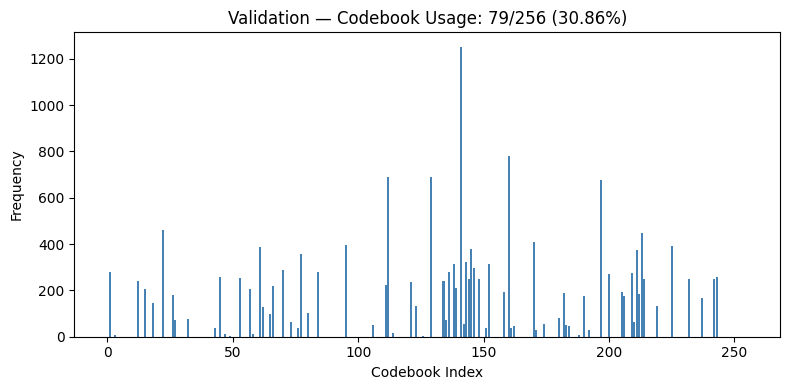

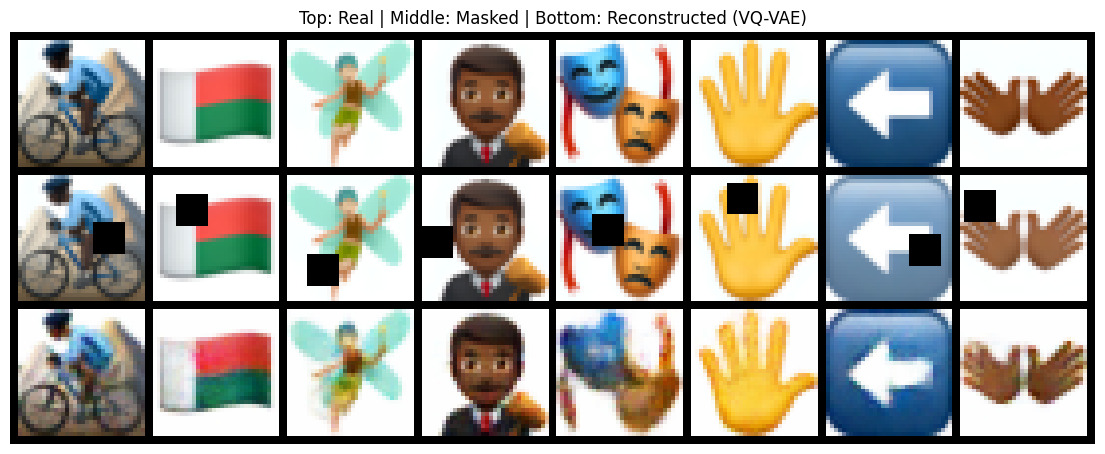

In [46]:
vqvae_model_in = vqvae_model_in.to(device)
validate_vqvae_in(vqvae_model_in, val_loader, device)

Validation: 100%|██████████| 9/9 [00:00<00:00, 11.80it/s]


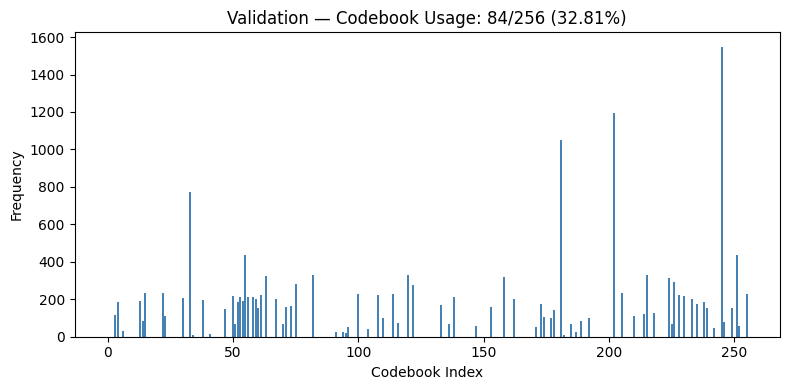

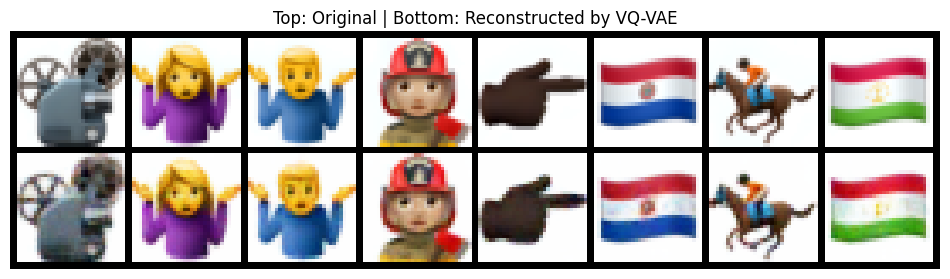

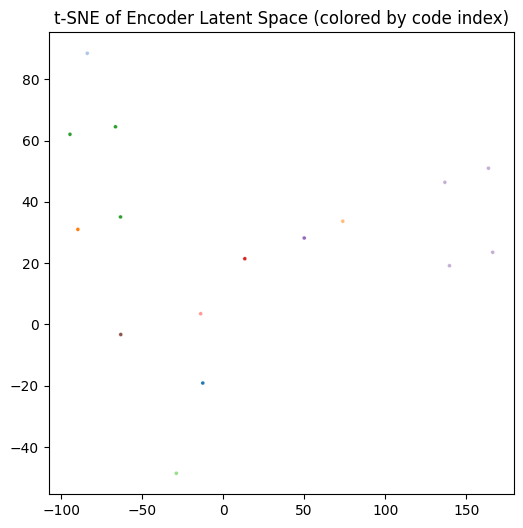

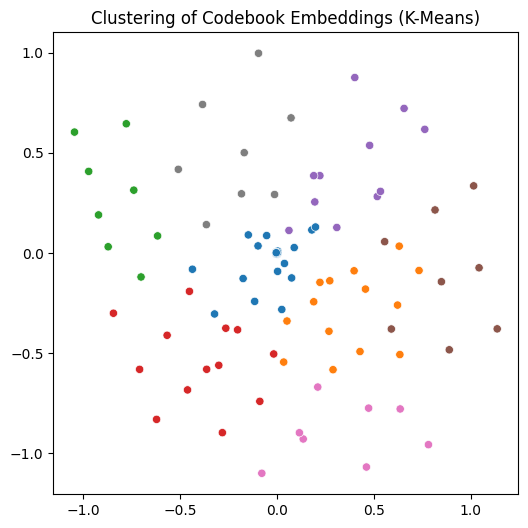

In [ ]:
# # Assuming you already have val_loader and device


# Load a batch of images from validation set
# vqvae_model = vqvae_model.to(device)

# imgs, _ = next(iter(val_loader))
# imgs = imgs.to(device)

# # Forward pass through model
# with torch.no_grad():
#     recon, _ = vqvae_model(imgs)

# # Select n images to visualize
# n = min(8, imgs.size(0))
# orig = imgs[:n].cpu()
# reconstructed = recon[:n].cpu()

# # Create grid: top row = original, bottom row = recon
# grid = torch.cat([orig, reconstructed], dim=0)
# grid = vutils.make_grid(grid, nrow=n, normalize=True, scale_each=True)

# # Show the grid
# plt.figure(figsize=(12, 6))
# plt.imshow(np.transpose(grid.numpy(), (1, 2, 0)))
# plt.title("Top: Original Emojis | Bottom: Reconstructed by VQ‑VAE")
# plt.axis('off')
# plt.show()
vqvae_model = vqvae_model.to(device)
validate_vqvae(vqvae_model, val_loader, device)
visualize_latent_representations(vqvae_model, val_loader, device, n_samples=16)

metrics

In [ ]:
# all metrics
import torch
import torch.nn.functional as F
from tqdm import tqdm
import numpy as np
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr

def evaluate_reconstruction_quality(model, dataloader, device, num_batches=100):
    model.eval()
    total_mse = 0
    total_ssim = 0
    total_psnr = 0
    sample_count=0
    with torch.no_grad():
        for i, (imgs, _) in enumerate(tqdm(dataloader, desc="Evaluating")):
            if i >= num_batches:
                break

            imgs = imgs.to(device)
            recon, _ = model(imgs)

            # Clamp to valid image range
            recon = recon.clamp(0.0, 1.0)

            for j in range(imgs.size(0)):
                img = imgs[j].cpu()
                rec = recon[j].cpu()

                # Compute MSE directly
                mse_val = F.mse_loss(rec, img).item()
                total_mse += mse_val

                # Convert to HWC NumPy arrays for SSIM/PSNR
                img_np = img.permute(1, 2, 0).numpy()
                rec_np = rec.permute(1, 2, 0).numpy()

                # Ensure values are within [0, 1]
                img_np = np.clip(img_np, 0, 1)
                rec_np = np.clip(rec_np, 0, 1)

                # Compute SSIM and PSNR on RGB
                ssim_val = ssim(img_np, rec_np, data_range=1.0, channel_axis=-1)
                psnr_val = psnr(img_np, rec_np, data_range=1.0)

                total_ssim += ssim_val
                total_psnr += psnr_val
            sample_count+=len(imgs)

    # num_samples = num_batches * dataloader.batch_size
    num_samples=sample_count
    avg_mse = total_mse / num_samples
    avg_ssim = total_ssim / num_samples
    avg_psnr = total_psnr / num_samples

    print(f"\nReconstruction MSE:  {avg_mse:.6f}")
    print(f"Reconstruction SSIM: {avg_ssim:.6f}")
    print(f"Reconstruction PSNR: {avg_psnr:.2f} dB")
    return avg_mse, avg_ssim, avg_psnr


In [ ]:
evaluate_reconstruction_quality(vqvae_model, train_loader, device)

Evaluating: 100%|██████████| 77/77 [00:11<00:00,  6.48it/s]


Reconstruction MSE:  0.001631
Reconstruction SSIM: 0.956241
Reconstruction PSNR: 29.37 dB


(0.0016313943377560002, np.float32(0.9562412), np.float64(29.37210089099139))

In [ ]:
evaluate_reconstruction_quality(vqvae_model, val_loader, device)

Evaluating: 100%|██████████| 9/9 [00:01<00:00,  8.88it/s]


Reconstruction MSE:  0.001806
Reconstruction SSIM: 0.953946
Reconstruction PSNR: 29.24 dB


(0.0018058112763207068, np.float32(0.9539455), np.float64(29.240146823905867))

metrics for inpainting

In [42]:
# all metrics
import torch
import torch.nn.functional as F
from tqdm import tqdm
import numpy as np
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr

def evaluate_reconstruction_quality_in(model, dataloader, device, num_batches=100):
    model.eval()
    total_mse = 0
    total_ssim = 0
    total_psnr = 0
    sample_count=0
    with torch.no_grad():
        for i, (imgs, _) in enumerate(tqdm(dataloader, desc="Evaluating")):
            if i >= num_batches:
                break

            imgs = imgs.to(device)
            masked_imgs, mask = random_mask(imgs)

            # Forward pass through the model
            recon, vq_loss = model(masked_imgs)

            # Compute reconstruction loss (optional for logging)
            recon_loss = F.mse_loss(recon, imgs)


            # Clamp to valid image range
            recon = recon.clamp(0.0, 1.0)

            for j in range(imgs.size(0)):
                img = imgs[j].cpu()
                rec = recon[j].cpu()

                # Compute MSE directly
                mse_val = F.mse_loss(rec, img).item()
                total_mse += mse_val

                # Convert to HWC NumPy arrays for SSIM/PSNR
                img_np = img.permute(1, 2, 0).numpy()
                rec_np = rec.permute(1, 2, 0).numpy()

                # Ensure values are within [0, 1]
                img_np = np.clip(img_np, 0, 1)
                rec_np = np.clip(rec_np, 0, 1)

                # Compute SSIM and PSNR on RGB
                ssim_val = ssim(img_np, rec_np, data_range=1.0, channel_axis=-1)
                psnr_val = psnr(img_np, rec_np, data_range=1.0)

                total_ssim += ssim_val
                total_psnr += psnr_val
            sample_count+=len(imgs)

    # num_samples = num_batches * dataloader.batch_size
    num_samples=sample_count
    avg_mse = total_mse / num_samples
    avg_ssim = total_ssim / num_samples
    avg_psnr = total_psnr / num_samples

    print(f"\nReconstruction MSE:  {avg_mse:.6f}")
    print(f"Reconstruction SSIM: {avg_ssim:.6f}")
    print(f"Reconstruction PSNR: {avg_psnr:.2f} dB")
    return avg_mse, avg_ssim, avg_psnr


In [43]:
evaluate_reconstruction_quality_in(vqvae_model_in, train_loader, device)

Evaluating: 100%|██████████| 77/77 [00:09<00:00,  8.34it/s]


Reconstruction MSE:  0.003699
Reconstruction SSIM: 0.908436
Reconstruction PSNR: 25.42 dB


(0.0036993877336664645, np.float32(0.9084356), np.float64(25.42189230811887))

In [44]:
evaluate_reconstruction_quality_in(vqvae_model_in, val_loader, device)

Evaluating: 100%|██████████| 9/9 [00:01<00:00,  6.36it/s]


Reconstruction MSE:  0.003760
Reconstruction SSIM: 0.911058
Reconstruction PSNR: 25.32 dB


(0.0037600585871206764, np.float32(0.91105765), np.float64(25.319304228418527))

now the pixelcnn

In [ ]:
class MaskedConv2d(nn.Conv2d):
    """
    Base class for Masked Convolution. Initializes a weight mask.
    Type A: Mask weights to zero for connections to the current pixel and future pixels.
    Type B: Mask weights to zero only for future pixels (allowing connection to the current pixel).
    """
    def __init__(self, mask_type, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.mask_type = mask_type
        self.register_buffer('mask', self.weight.data.clone())

        # Create mask based on kernel size
        _, _, kH, kW = self.weight.size()
        self.mask.fill_(1)

        # Center of the kernel
        center_h, center_w = kH // 2, kW // 2

        # 1. Mask future pixels (below center_h, or to the right of center_w)
        self.mask[:, :, center_h + 1:, :] = 0
        self.mask[:, :, center_h, center_w + 1:] = 0

        # 2. Type A specific mask: also mask the center pixel
        if mask_type == 'A':
            self.mask[:, :, center_h, center_w] = 0

    def forward(self, x):
        # Apply the mask to the weights before convolution
        self.weight.data *= self.mask
        return super().forward(x)


class PixelCNNBlock(nn.Module):
    """A standard PixelCNN block using MaskedConv2d_B."""
    def __init__(self, hidden_dim):
        super().__init__()
        self.block = nn.Sequential(
            nn.ReLU(),
            MaskedConv2d('B', hidden_dim, hidden_dim, kernel_size=3, padding=1),
            nn.BatchNorm2d(hidden_dim) # Use Batch Norm (or Weight Norm)
        )

    def forward(self, x):
        return x + self.block(x)



class PixelCNN(nn.Module):
    """
    PixelCNN model to learn the prior distribution over the VQVAE's codebook indices.
    Input: B x H x W (indices from 0 to num_embeddings - 1)
    Output: B x num_embeddings x H x W (logits for each index at each position)
    """
    def __init__(self, input_channels, hidden_dim, num_embeddings, num_layers=20):
        super().__init__()

        # 1. Input embedding: Convert discrete indices to a dense vector (B x D x H x W)
        self.embedding = nn.Embedding(num_embeddings, input_channels)

        # 2. Initial Mask A layer (removes current pixel dependency)
        layers = [
            MaskedConv2d('A', input_channels, hidden_dim, kernel_size=7, padding=3),
            nn.BatchNorm2d(hidden_dim)
        ]

        # 3. Subsequent Mask B layers (allows dependency on current pixel's previous channels, not applicable here)
        # There are no multiple channels within a pixel to order — each “pixel” (codebook index) is just one number!!
        # Using residual blocks for better performance
        for _ in range(num_layers):
            layers.append(PixelCNNBlock(hidden_dim))

        # 4. Final layers to map back to the number of codebook entries (logits)
        layers.extend([
            nn.ReLU(),
            MaskedConv2d('B', hidden_dim, hidden_dim, kernel_size=1),
            nn.ReLU(),
            MaskedConv2d('B', hidden_dim, num_embeddings, kernel_size=1) # Output logits for all embeddings
        ])

        self.net = nn.Sequential(*layers)

    def forward(self, x):
        # x is B x H x W (long indices)
        B, H, W = x.shape
        x_emb = self.embedding(x).permute(0, 3, 1, 2) # B x D x H x W

        logits = self.net(x_emb) # B x num_embeddings x H x W
        return logits

now training, sampling and generation code

In [ ]:
def train_pixelcnn(vqvae_model, pixelcnn_model, latent_loader, device, epochs=10):
    """
    Trains the PixelCNN model using the pre-calculated latent codes.
    VQVAE weights must be frozen (already handled by vqvae_model.eval() and requires_grad=False).
    """
    pixelcnn_model.to(device)
    pixelcnn_model.train()

    # Freeze VQVAE weights
    vqvae_model.eval()
    for param in vqvae_model.parameters():
        param.requires_grad = False

    optimizer = torch.optim.Adam(pixelcnn_model.parameters(), lr=2e-4) # changed lr here!!
    criterion = nn.CrossEntropyLoss()

    print("\n--- Starting PixelCNN Training ---")

    for epoch in range(epochs):
        epoch_loss = 0
        # Explicitly unpack the single tensor from the latent_loader batch
        for (target_codes,) in latent_loader:
            target_codes = target_codes.to(device) # B x H_latent x W_latent

            # 2. Forward pass through PixelCNN
            logits = pixelcnn_model(target_codes) # B x num_embeddings x H_latent x W_latent

            # 3. Calculate Loss (Cross-Entropy)
            loss = criterion(logits, target_codes)

            # 4. Backpropagate
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
        if epoch % 20 == 0:
            # Save model
            torch.save(pixelcnn_model.state_dict(), "/content/drive/MyDrive/vqvae_emoji32_pixelcnn.pth")

        print(f"Epoch {epoch+1}/{epochs} Loss: {epoch_loss / len(latent_loader):.4f}")

sample and generate function

In [ ]:
def sample_and_generate(vqvae_model, pixelcnn_model, device, num_samples=4):
    """
    Generates new images by sampling latent codes autoregressively from the PixelCNN,
    and then decoding the codes using the VQVAE decoder.
    """
    vqvae_model.to(device)
    vqvae_model.eval()
    pixelcnn_model.to(device)
    pixelcnn_model.eval()

    # Latent size for 32x32 image with two stride-2 convs is 8x8
    latent_h, latent_w = 8, 8

    # Initialize the generated code map (B x H x W)
    generated_codes = torch.zeros(
        (num_samples, latent_h, latent_w),
        dtype=torch.long,
        device=device
    )

    print("\n--- Starting Autoregressive Sampling ---")

    with torch.no_grad():
        for i in range(latent_h):
            for j in range(latent_w):
                # Input the partially generated code map to the PixelCNN
                logits = pixelcnn_model(generated_codes)

                # Get the logits for the current pixel (i, j)
                # Logits is B x C x H x W. We extract B x C
                current_logits = logits[:, :, i, j]

                # Sample the next code index using the probabilities (softmax)
                probs = F.softmax(current_logits, dim=1)
                sampled_indices = torch.multinomial(probs, num_samples=1).squeeze(-1) # B x 1 -> B

                # Update the generated code map
                generated_codes[:, i, j] = sampled_indices

    print("Sampling complete. Decoding codes...")

    # Decode the final generated codes back into images
    generated_images = vqvae_model.decode_codes(generated_codes)

    # Simple output simulation:
    print(f"Successfully generated {num_samples} images of shape: {generated_images.shape}")

    return generated_images


codebook analysis for generation function

In [ ]:
def sample_and_generate2(vqvae_model, pixelcnn_model, device, num_samples=4):
    """
    Generates new images by sampling latent codes autoregressively from the PixelCNN,
    and then decoding them using the VQVAE decoder.
    Also visualizes how frequently codebook indices were used.
    """
    vqvae_model.to(device)
    vqvae_model.eval()
    pixelcnn_model.to(device)
    pixelcnn_model.eval()

    # Latent map size for 32x32 inputs (after 2 stride-2 convs)
    latent_h, latent_w = 8, 8

    # Initialize empty latent code map
    generated_codes = torch.zeros(
        (num_samples, latent_h, latent_w),
        dtype=torch.long,
        device=device
    )

    print("\n--- Starting Autoregressive Sampling ---")

    with torch.no_grad():
        for i in range(latent_h):
            for j in range(latent_w):
                # PixelCNN predicts logits over codebook indices given current map
                logits = pixelcnn_model(generated_codes)  # (B, num_embeddings, H, W)

                # Extract logits for current spatial position (i, j)
                current_logits = logits[:, :, i, j]  # (B, num_embeddings)

                # Convert to probabilities and sample next index
                probs = F.softmax(current_logits, dim=1)
                sampled_indices = torch.multinomial(probs, num_samples=1).squeeze(-1)  # (B,)

                # Update the generated code map
                generated_codes[:, i, j] = sampled_indices

    print("Sampling complete. Decoding codes...")

    # Plot codebook usage before decoding
    analyze_codebook_usage(vqvae_model, generated_codes, phase="Generation (PixelCNN Samples)")

    # Decode final generated codes into images
    generated_images = vqvae_model.decode_codes(generated_codes)

    print(f"Successfully generated {num_samples} images of shape: {generated_images.shape}")

    # Visualize generated images
    visualize_generated_images(generated_images, title="Generated Images (PixelCNN + VQ-VAE)")

    return generated_images


function to create a dataloader for latent codes

In [ ]:
def get_latent_code_dataloader(vqvae_model, image_loader, device, batch_size):
    """
    STEP 2.5: Pre-calculates all latent codes using the VQVAE and returns a DataLoader
    that yields only the codes, simplifying PixelCNN training.

    Also logs:
      • Batch-wise codebook usage ratio
      • Global codebook usage
      • Frequency distribution of code usage
    """
    vqvae_model.to(device)
    vqvae_model.eval()
    all_latent_codes = []

    print("\n--- Pre-calculating latent codes for PixelCNN ---")

    # Initialize a frequency counter for each codebook index
    code_freq = torch.zeros(CODEBOOK_SIZE, dtype=torch.long)

    with torch.no_grad():
        for i, (images,_) in enumerate(image_loader):
            images = images.to(device)

            # Get discrete latent codes (B x H x W)
            codes = vqvae_model.get_latent_codes(images)
            codes_cpu = codes.detach().cpu()

            # Sanity checks
            min_code, max_code = codes_cpu.min().item(), codes_cpu.max().item()
            assert min_code >= 0, f"Invalid code {min_code}"
            assert max_code < CODEBOOK_SIZE, f"Invalid code {max_code}"
            # print(f"Batch {i}: min={min_code}, max={max_code}")

            # Count frequency of each code in this batch
            batch_counts = torch.bincount(codes_cpu.view(-1), minlength=CODEBOOK_SIZE)
            code_freq += batch_counts

            # Batch usage ratio
            unique_codes = (batch_counts > 0).sum().item()
            usage_ratio = unique_codes / CODEBOOK_SIZE * 100
            # print(f"→ Codebook usage (this batch): {unique_codes}/{CODEBOOK_SIZE} "
            #       f"({usage_ratio:.2f}%)")

            all_latent_codes.append(codes_cpu)

    # Global usage across dataset
    used_codes = (code_freq > 0).sum().item()
    global_usage_ratio = used_codes / CODEBOOK_SIZE * 100
    print(f"\nGlobal codebook usage: {used_codes}/{CODEBOOK_SIZE} "
          f"({global_usage_ratio:.2f}%)")

    # Print summary stats for how evenly codes are used
    nonzero_freq = code_freq[code_freq > 0].float()
    print(f"Average usage (nonzero codes): {nonzero_freq.mean():.2f}")
    print(f"Min usage: {nonzero_freq.min():.0f}, Max usage: {nonzero_freq.max():.0f}")

    # 🔍 Plot histogram of code frequencies
    plt.figure(figsize=(8, 4))
    plt.bar(torch.arange(CODEBOOK_SIZE).numpy(), code_freq.numpy(), color='royalblue')
    plt.title(f"Codebook Index Usage (Total {used_codes}/{CODEBOOK_SIZE})")
    plt.xlabel("Codebook Index")
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()

    # Combine all latent codes into a single dataset
    full_codes_tensor = torch.cat(all_latent_codes, dim=0)
    latent_dataset = TensorDataset(full_codes_tensor)
    latent_loader = DataLoader(latent_dataset, batch_size=batch_size, shuffle=True)

    print(f"Latent codes generated. Total samples: {full_codes_tensor.size(0)}")
    return latent_loader


see codebook index usage in validation set

In [ ]:
latent_code_loader = get_latent_code_dataloader(vqvae_model, val_loader, device, BATCH_SIZE)

running the traning

In [ ]:
pixelcnn_model = PixelCNN(
    input_channels=EMBEDDING_DIMENSION, # corrected: should be equal to z_dim of vqvae
    # was 64 earlier
    hidden_dim=HIDDEN_DIMENSION,
    num_embeddings=CODEBOOK_SIZE,
    num_layers=PIXEL_CNN_LAYERS
)


latent_code_loader = get_latent_code_dataloader(vqvae_model, train_loader, device, BATCH_SIZE)
train_pixelcnn(vqvae_model, pixelcnn_model, latent_code_loader, device, epochs=300)

visualize generated images

In [ ]:
def visualize_generated_images(images_tensor, title="Generated VQVAE Images"):
    """
    Takes a batch of images (B x C x H x W) and visualizes them in a grid using Matplotlib.
    """
    images_numpy = images_tensor.detach().cpu().numpy()

    # Transpose from B x C x H x W to B x H x W x C (required for matplotlib imshow)
    images_numpy = images_numpy.transpose(0, 2, 3, 1)

    # Determine grid size (e.g., 2 rows, 4 columns for 8 images)
    num_images = images_numpy.shape[0]
    # Restrict to a maximum of 8 columns for readability
    cols = min(8, num_images)
    rows = (num_images + cols - 1) // cols

    # Handle the single image case
    if num_images == 1:
        rows, cols = 1, 1

    # Create subplots
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 2, rows * 2))
    fig.suptitle(title, fontsize=16)

    # Flatten axes array for easy iteration
    axes = axes.flatten() if num_images > 1 else [axes]

    for i in range(num_images):
        ax = axes[i]
        # Clip values to ensure they are in [0, 1] range for visualization
        ax.imshow(np.clip(images_numpy[i], 0, 1))
        ax.axis('off') # Hide axes

    # Turn off remaining unused subplots if num_images < rows * cols
    for i in range(num_images, len(axes)):
        axes[i].axis('off')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()



save weights of the pixelcnn

In [ ]:
# Save model
torch.save(pixelcnn_model.state_dict(), "/content/drive/MyDrive/vqvae_emoji32_pixelcnn.pth")


load pixelcnn model

In [ ]:
pixelcnn_model = pixelcnn_model = PixelCNN(
    input_channels=EMBEDDING_DIMENSION,
    hidden_dim=HIDDEN_DIMENSION,
    num_embeddings=CODEBOOK_SIZE,
    num_layers=PIXEL_CNN_LAYERS
)
vqvae_model.load_state_dict(torch.load("/content/drive/MyDrive/vqvae_emoji32.pth", map_location=device))
vqvae_model.eval()
pixelcnn_model.load_state_dict(torch.load("/content/drive/MyDrive/vqvae_emoji32_pixelcnn.pth", map_location=device))
pixelcnn_model.eval()

Compute FID

In [ ]:
def get_real_images_subset(dataloader, device, n_samples):
    """Collects a fixed number of real images from the dataloader."""
    real_images = []
    current_count = 0
    for images, _ in dataloader:
        if current_count >= n_samples:
            break

        # Only take what is needed to reach n_samples
        take_count = min(images.size(0), n_samples - current_count)
        real_images.append(images[:take_count].to(device))
        current_count += take_count

    return torch.cat(real_images, dim=0)


def compute_fid(real_dataloader, generated_images, device):
    """
    Calculates the FID score between the distribution of real images and the
    distribution of generated images.
    """
    num_generated = generated_images.size(0)
    print(f"\n--- Calculating Generative FID (Real vs. PixelCNN Generated, N={num_generated}) ---")

    # 1. Collect a matching subset of real images
    real_images = get_real_images_subset(real_dataloader, device, num_generated)

    if real_images.size(0) != num_generated:
        print("WARNING: Could not collect enough real samples to match generated samples. Skipping FID.")
        return None

    # 2. FID requires images in the range [0, 255] and torch.uint8 dtype
    real_imgs_uint8 = (real_images * 255).clamp(0, 255).to(torch.uint8)
    fake_imgs_uint8 = (generated_images * 255).clamp(0, 255).to(torch.uint8)

    # --- FID SIMULATION START ---
    # In a real environment, you would:
    fid_metric = FrechetInceptionDistance(feature=2048).to(device)
    fid_metric.update(real_imgs_uint8, real=True)
    fid_metric.update(fake_imgs_uint8, real=False)
    fid_score = fid_metric.compute().item()

    print(f"FID Score (Lower is better, typically <10 is good): {fid_score:.2f}")
    return fid_score

compute the fid

In [ ]:
generated_images1 = sample_and_generate(vqvae_model, pixelcnn_model, device, num_samples=100)
compute_fid(train_loader, generated_images1, device)

see codebook usage

In [ ]:
generated_images = sample_and_generate2(vqvae_model, pixelcnn_model, device, num_samples=16)

see vqvae + pixelcnn generated images

In [ ]:
generated_images = sample_and_generate(vqvae_model, pixelcnn_model, device, num_samples=16)
visualize_generated_images(generated_images, "VQVAE + PixelCNN generated images")

see clustering for generated images

In [ ]:
class TensorDataset(torch.utils.data.Dataset):
    def __init__(self, images):
        self.images = images  # already a torch.Tensor [B, C, H, W]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        return self.images[idx], 0  # dummy label

gen_loader = DataLoader(TensorDataset(generated_images), batch_size=BATCH_SIZE, shuffle=False)
visualize_latent_representations(vqvae_model, gen_loader, device, n_samples=16)


latent interpolation try

In [ ]:
def run_latent_interpolation(vqvae_model, image_loader, device, steps=10):
    """
    Performs linear interpolation between the continuous latent codes (z_e) of two
    randomly selected images and returns the resulting morphing sequence.
    """
    vqvae_model.to(device)
    vqvae_model.eval()

    # 1. Get two distinct images from the loader
    images, _ = next(iter(image_loader))

    if images.size(0) < 2:
        print("Error: Loader batch size too small for interpolation.")
        return []

    # Select the first two images from the batch
    img1 = images[0].unsqueeze(0).to(device) # 1 x C x H x W
    img2 = images[1].unsqueeze(0).to(device) # 1 x C x H x W

    print(f"\n--- Starting Latent Interpolation between two images in {steps} steps ---")

    with torch.no_grad():
        # 2. Encode images to continuous latent space (z_e)
        z_e1 = vqvae_model.encoder(img1)
        z_e2 = vqvae_model.encoder(img2)

        interpolated_images = []

        for i in range(steps):
            # Interpolation factor from 0.0 to 1.0
            t = i / (steps - 1)

            # 3. Linear interpolation in continuous latent space
            z_interp = (1 - t) * z_e1 + t * z_e2

            # 4. Quantize the interpolated latent code (z_interp -> z_q)
            # We call the quantizer's forward method directly.
            z_q, _, _ = vqvae_model.quantizer(z_interp)

            # 5. Decode the quantized latent code
            x_interp = vqvae_model.decoder(z_q)

            # Store the reconstructed image
            interpolated_images.append(x_interp.squeeze(0).cpu())

    print("Interpolation and decoding complete.")
    return interpolated_images

def visualize_interpolation(images, title="Latent Space Interpolation"):
    """Visualizes the sequence of interpolated images."""
    num_images = len(images)

    fig, axes = plt.subplots(1, num_images, figsize=(num_images * 2, 3))
    fig.suptitle(title, fontsize=16)

    # Flatten axes array for easy indexing, even if only one image is generated
    axes = axes.flatten() if num_images > 1 else [axes]

    for i in range(num_images):
        # Convert tensor to numpy, transpose to H x W x C
        img_numpy = images[i].numpy().transpose(1, 2, 0)

        ax = axes[i]
        ax.imshow(np.clip(img_numpy, 0, 1))
        ax.axis('off')
        if i == 0:
            ax.set_title("Start", fontsize=10)
        elif i == num_images - 1:
            ax.set_title("End", fontsize=10)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


In [ ]:
INTERPOLATION_STEPS = 12
interpolated_sequence = run_latent_interpolation(
    vqvae_model,
    val_loader, # Use validation set for sourcing images
    device,
    steps=INTERPOLATION_STEPS
)
if interpolated_sequence:
    visualize_interpolation(interpolated_sequence, f"Latent Interpolation ({INTERPOLATION_STEPS} Steps)")